In [24]:
%matplotlib inline
import random
from collections import defaultdict
import itertools
import glob
import os
import functools

import numpy as np
import scanpy 
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_1samp
import seaborn as sns
from tqdm.auto import tqdm
# Show HTML tables inline
from IPython.display import display, HTML

import anndata

anndata.__version__

scanpy.settings.verbosity = 4
#sc.set_figure_params(dpi=200, dpi_save=300)
scanpy.logging.print_versions()
scanpy.set_figure_params(frameon=False, color_map='magma_r')

scanpy==1.4.6 anndata==0.7.1 umap==0.3.9 numpy==1.16.1 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.22.1 statsmodels==0.11.1 python-igraph==0.7.1 louvain==0.6.1


In [ ]:
# Here is the link to the figures - https://docs.google.com/presentation/d/12fuR5JBbB5rXLtzHc0qVn4LP8SZ3npA50ac5FMIb6dA/edit?usp=sharing

1. Combine parquet files per cell type per compartment group
2. Goal - cell types in mouse lemur that are close to human than mouse
3. For each of the compartment_group, broad_group, narrow_group
4. make this plot (under title “violinplot + factorplot for presentation”)
5. From Olga: I think the current sorting is by a t-statistic of how different
   mouse-mouse lemur distributions are, but I think a better sorting is by mouse lemur to human similarity

In [25]:
PARQUETS_PATH = "/mnt/ibm_lg/pranathi/tabula-microcebus-results/parquets"
parquet_format = ".parquet"
parquet_files = glob.glob(os.path.join(PARQUETS_PATH, "*" + parquet_format))
print(len(parquet_files))

95


In [26]:
between_celltypes = [parquet for parquet in parquet_files if parquet.endswith("between_celltypes.parquet")]
within_celltypes = [parquet for parquet in parquet_files if not parquet.endswith("between_celltypes.parquet") and "between_celltypes" not in parquet]

print(len(between_celltypes))
print(len(within_celltypes))

assert len(between_celltypes) == len(within_celltypes)

44
44


# Combine per group for all the cell types
For each group, we have the following number of cell types
1. compartment group - 5 cell types
2. broad group - 17 cell types
3. narrow group - 20 cell types

In [27]:
COMPARTMENT_GROUPS = [
    'endothelial', 'epithelial', 'lymphoid', 'myeloid', 'stromal']
BROAD_GROUPS = [
    'Alveolar Epithelial Type 2', 'B cell', 'Capillary',
    'Ciliated', 'Dendritic', 'Fibroblast', 'Lymphatic', 'Macrophage',
    'Monocyte', 'Natural Killer', 'Natural Killer T cell', 'Pericyte',
    'Plasma',
    'Proliferating NK/T', 'Smooth Muscle and Myofibroblast', 'T cell', 'Vein']
NARROW_GROUPS = [
    'Adventitial Fibroblast', 'Alveolar Epithelial Type 2',
    'Alveolar Fibroblast', 'B cell', 'CD4+ T', 'Capillary',
    'Capillary Aerocyte', 'Ciliated', 'Lymphatic', 'Macrophage',
    'Monocyte', 'Myeloid Dendritic', 'Natural Killer', 'Natural Killer T cell',
    'Pericyte', 'Plasma', 'Plasmacytoid Dendritic',
    'Proliferating Macrophage', 'Proliferating NK_T', 'Vein']
GROUPS = ["compartment", "broad", "narrow"]
SUBGROUPS = {
    "endothelial": ["Capillary", "Capillary Aerocyte", "Lymphatic", "Vein"],
    "epithelial": ["Alveolar Epithelial Type 2", "Ciliated"],
    "lymphoid": ["B Cell", "CD4+ T", "CD8+ T", "Natural Killer", "Natural Killer T Cell", "Plasma", "Proliferating NK/T"],
    "myeloid": ["Macrophage", "Monocyte", "Myeloid Dendritic", "Plasmacytoid Dendritic", "Proliferating Macrophage"], 
    "stromal": ["Adventitial Fibroblast", "Alveolar Fibroblast", "Pericyte", "Airway Smooth Muscle and Myofibroblast"]}
SUBGROUPS_WITH_SIGNIFICANT_DATA = {
    'endothelial': ['Capillary', 'Capillary Aerocyte', 'Lymphatic'],
     'epithelial': ['Alveolar Epithelial Type 2'],
     'lymphoid': ['CD4+ T', 'Natural Killer', 'Plasma', 'Proliferating NK/T'],
     'myeloid': ['Macrophage', 'Monocyte', 'Myeloid Dendritic', 'Proliferating Macrophage'],
     'stromal': ['Adventitial Fibroblast', 'Alveolar Fibroblast']}
NARROW_CELL_TYPES_SIGNIFICANT = []
for key, value in SUBGROUPS_WITH_SIGNIFICANT_DATA.items():
    NARROW_CELL_TYPES_SIGNIFICANT.extend(value)

{'endothelial': (0.4, 0.7607843137254902, 0.6470588235294118),
 'epithelial': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 'lymphoid': (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 'myeloid': (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 'stromal': (0.6509803921568628, 0.8470588235294118, 0.32941176470588235)}

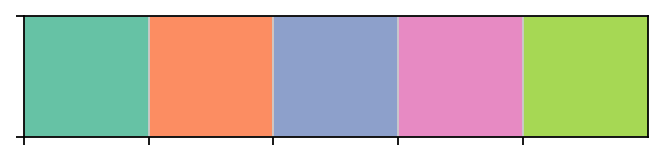

In [28]:
compartments = sorted(COMPARTMENT_GROUPS)
n_compartments = len(compartments)
compartment_colors = sns.color_palette("Set2", n_colors=n_compartments)
sns.palplot(compartment_colors)
compartment_to_color = dict(zip(compartments, compartment_colors))
compartment_to_color

In [29]:
# Combining parquet files
dfs_within = defaultdict(list)
for file in within_celltypes:
    for group in GROUPS:
        if group in file:
            df = pd.read_parquet(file)
            df = df.rename(columns={group + "_group": "cell_ontology_class"})
            dfs_within[group].append(df)

In [30]:
# Combining parquet files
dfs_between = defaultdict(list)
for file in between_celltypes:
    for group in GROUPS:
        if group in file:
            df = pd.read_parquet(file)
            df = df.rename(columns={
                    group + "_group1": "cell_ontology_class1",
                    group + "_group2": "cell_ontology_class2"})
            dfs_between[group].append(df)
print(len(dfs_between))

3


In [31]:
# Lets look at data from compartment group within the same celltype, xi correlation across species and visualize it
# what dataframe do we want to visualize
# what 

In [32]:
def compute_ttest(df, species2a="Mouse", species2b='Mouse lemur', col='xi'):
    df2a = df.query('species2 == @species2a')
    df2b = df.query('species2 == @species2b')
    
    a = df2a[col]
    b = df2b[col]
    statistic, pvalue = ttest_ind(a, b, equal_var=True)
    series = pd.Series([statistic, pvalue], index=['statistic', 'p_value'])
    return series

In [33]:
def compute_ttest_1samp(df, col='xi'):
    a = df[col]
    statistic, pvalue = ttest_1samp(a, 0.0)
    series = pd.Series([statistic, pvalue], index=['statistic', 'p_value'])
    return series

# Violin plot comparing within cell types for each of the groups

In [34]:
def corr(df):
    # species1 - Human species2 - anything
    correlation_df_human_vs = df.query('species1 == "Human"')

    # species1 - Human species2 - Human    
    correlation_df_human_vs_human = correlation_df_human_vs.query('species2 == "Human"')

    # species1 - Human species2 - anything but human
    correlation_df_human_vs_no_human_background = correlation_df_human_vs.query('species2 != "Human"')

    # apply ttest on cell_ontology_class for species1 - Human species2 - anything dataframe
    correlation_ttests = correlation_df_human_vs.groupby('cell_ontology_class').apply(compute_ttest)
    correlation_ttests['p_value_bonferonni'] = correlation_ttests.p_value * len(correlation_ttests.index)

    # comparison between human and other species as violin plot
    g = sns.catplot(y='cell_ontology_class', x='xi', hue='species2', 
                   data=correlation_df_human_vs_no_human_background, kind='violin', aspect=0.5, height=6, split=True,
                   order=correlation_ttests.index)

    # background point plot
    sns.pointplot(y='cell_ontology_class', x='xi', hue='species2', 
        ax=g.ax, data=correlation_df_human_vs_human, alpha=0.5, 
                  palette=['lightgrey'], legend=False, zorder=-100, order=correlation_ttests.index)
    g.ax.get_legend().remove()
    g.fig.set_figheight(12)
    g.fig.set_figwidth(12)
    plt.tight_layout()
    plt.show()
    return g

153000


/home/pranathi/miniconda3/lib/python3.7/site-packages/seaborn-0.10.0-py3.7.egg/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


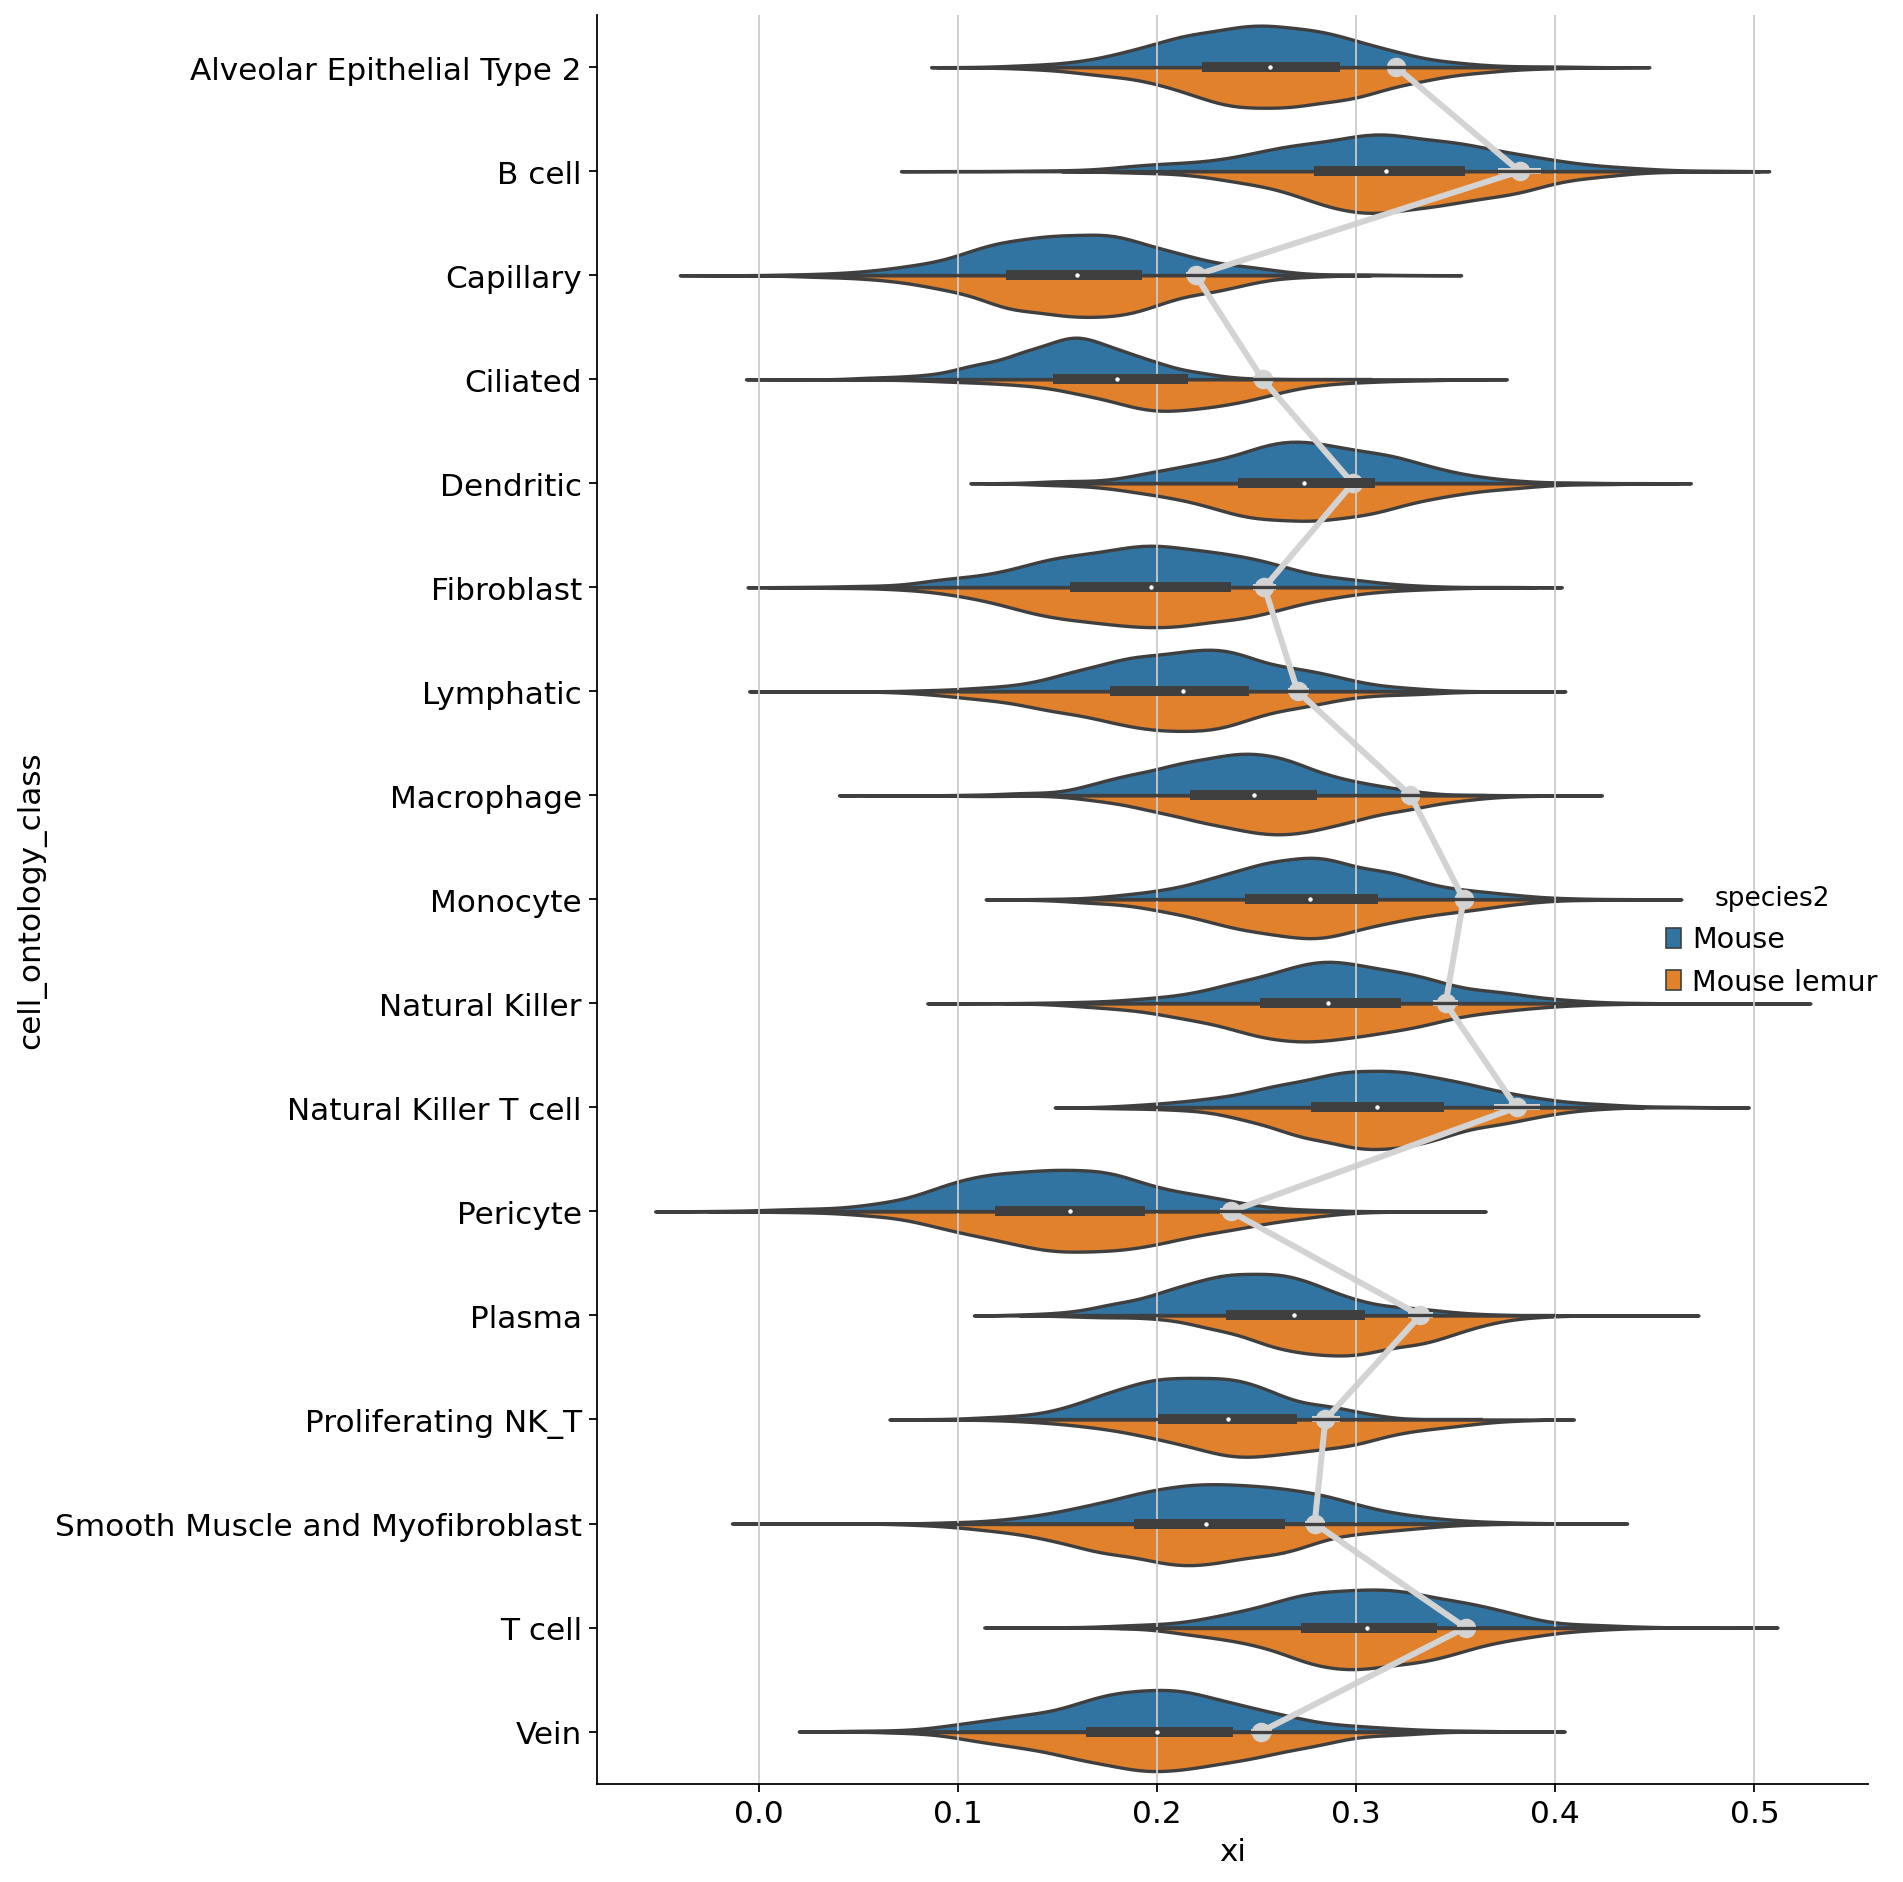

198000


/home/pranathi/miniconda3/lib/python3.7/site-packages/seaborn-0.10.0-py3.7.egg/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


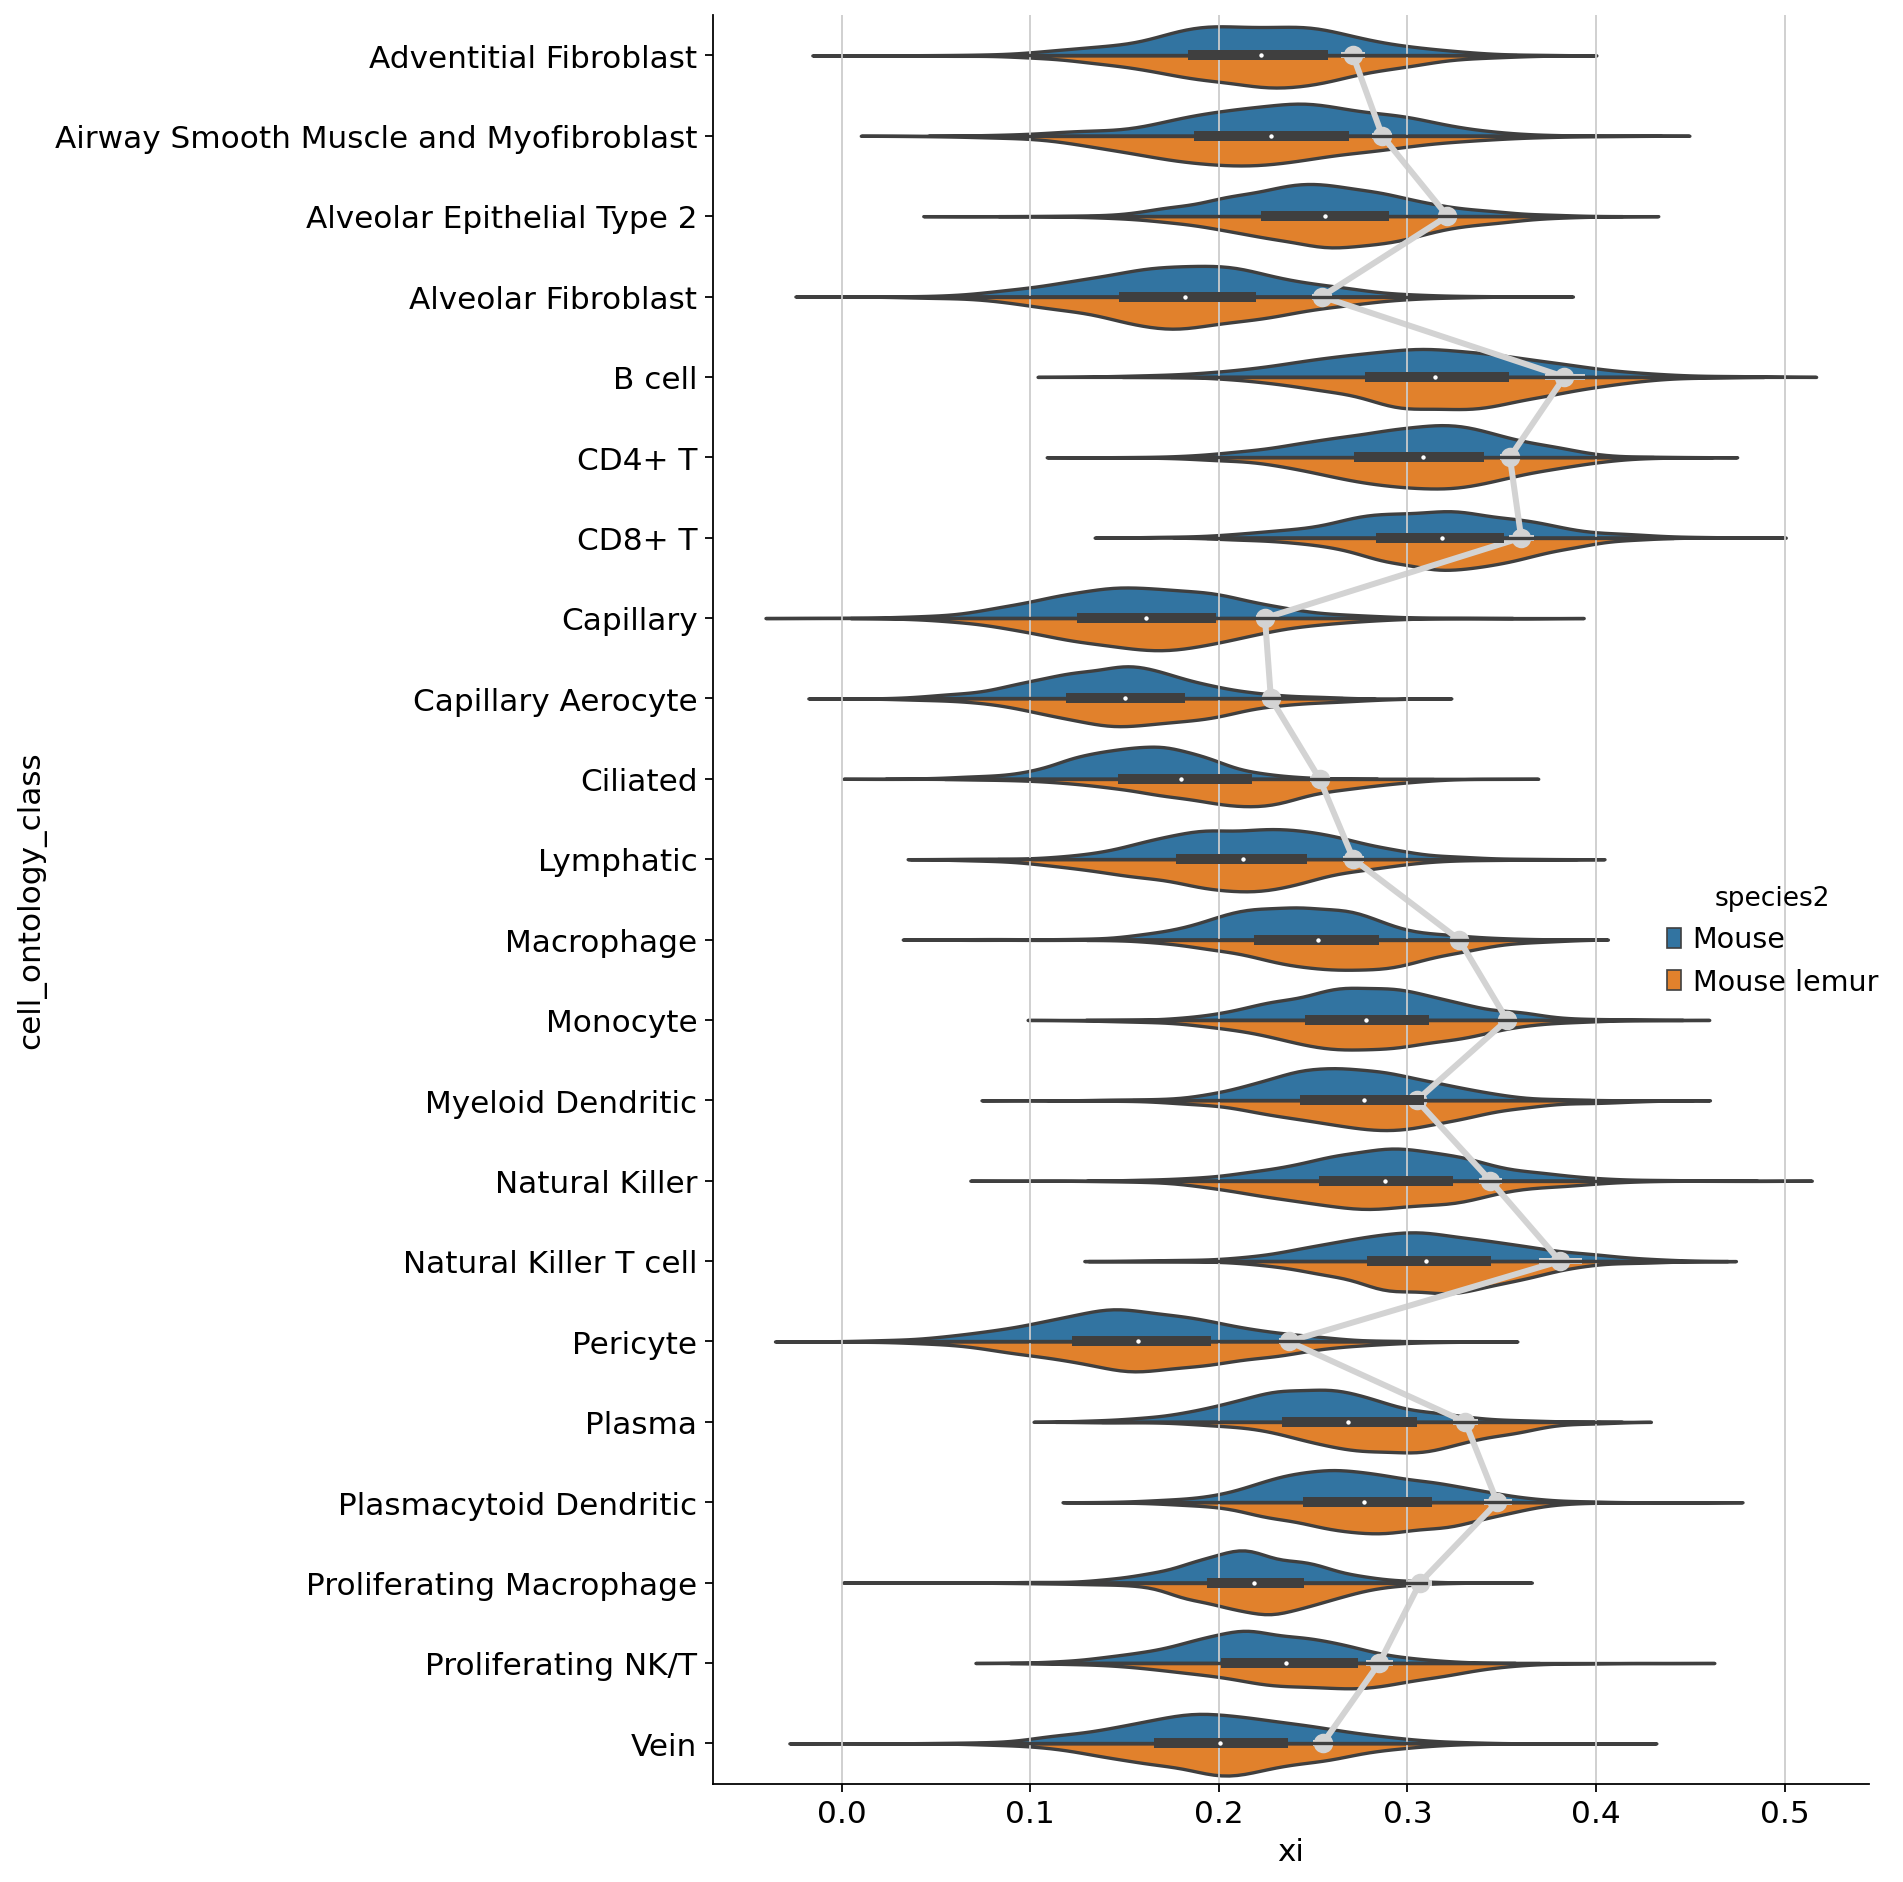

45000


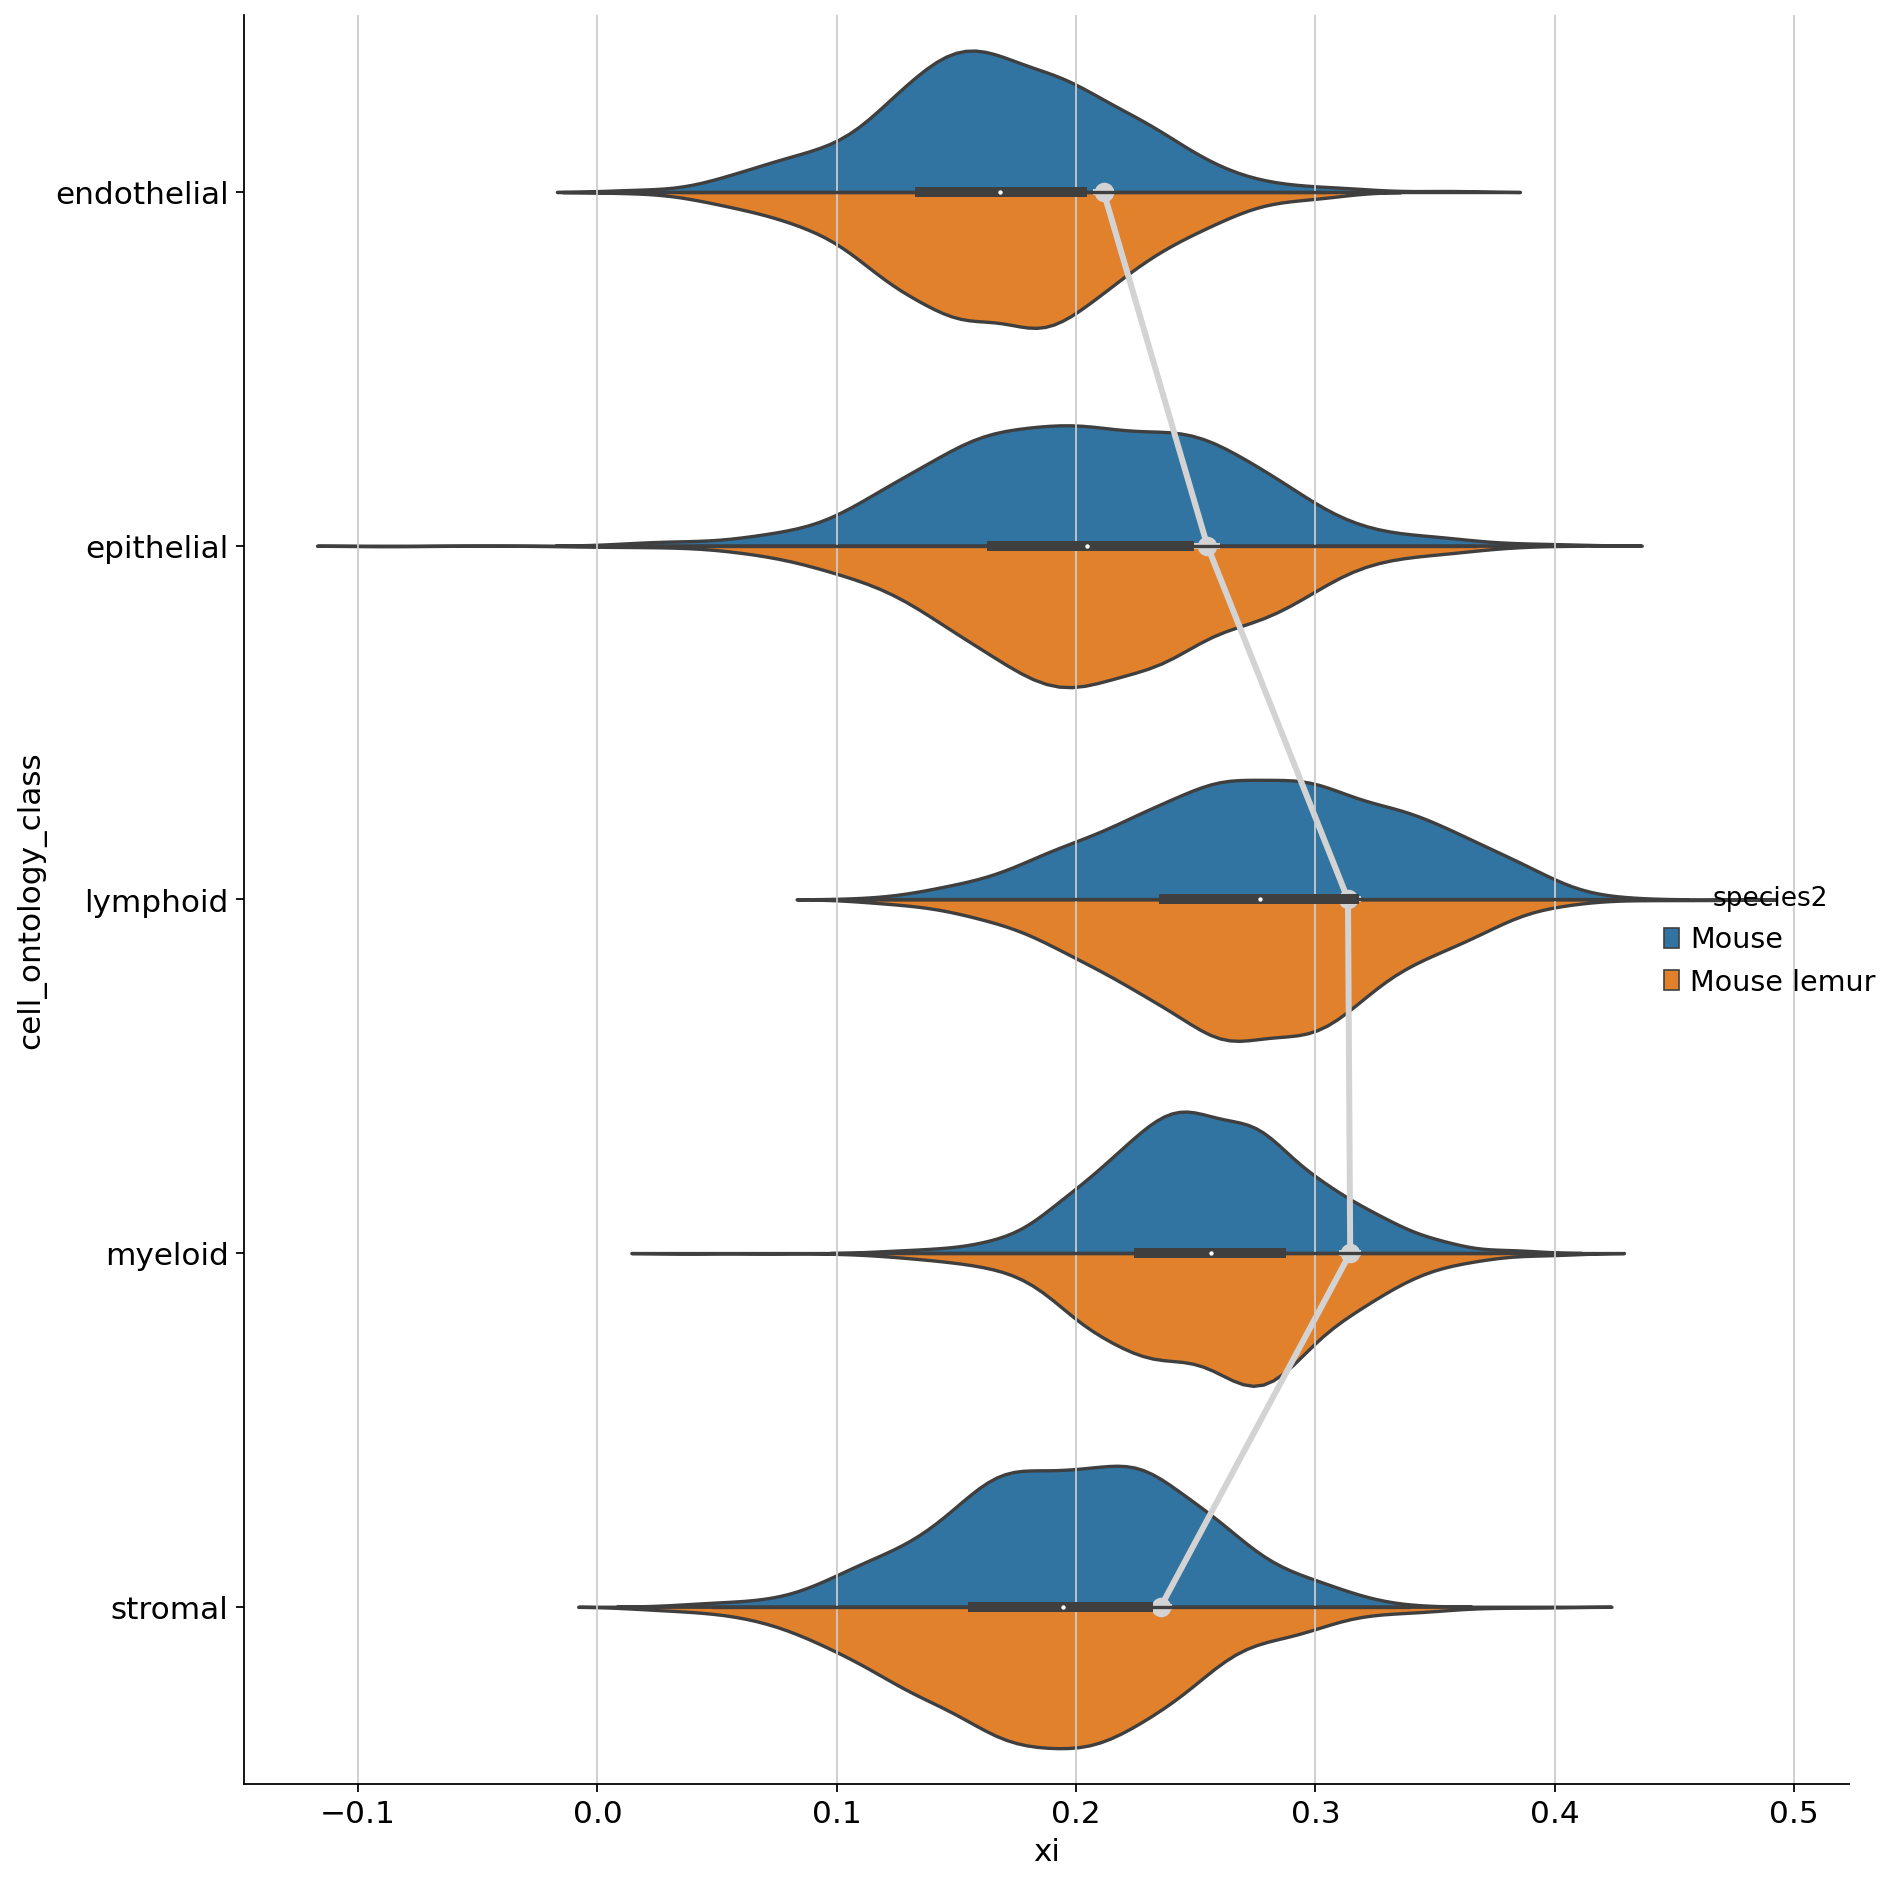

In [35]:
figures_within = {}
for group, dfs in dfs_within.items():
    df = pd.concat(dfs)
    print(len(df))
    df.head(4)
    figures_within[group] = corr(df)

# Pseudo code for between celltypes correlation

1. Between cell types - median of correlation
2. Medians = df.groupby([“celltype1”, “celltype2”, “species1”, “species2”]).xi.median()
3. This many need to be renamed, e.g:
   medians = medians.rename(columns={‘oldcolumname’: ‘median’})
4. Pivoted = medians.pivot_table(index=[‘species1’, ‘celltype1’], columns=[‘species2’, ‘celltype2’], values=’median’)
5. heatmap

In [36]:
def median_heatmap_between(df):
    median = df.groupby(["cell_ontology_class1", "cell_ontology_class2", "species1", "species2"]).xi.median()
    median = median.to_frame()
    median = median.rename(columns={"xi": "median"})
    subset = median[np.in1d(median.index.get_level_values(2), ['Mouse lemur'])]
    subset = subset[np.in1d(subset.index.get_level_values(3), ['Human', 'Mouse'])]
    pivoted = subset.pivot_table(
        index=["cell_ontology_class1", "species1"],
        columns=["cell_ontology_class2", "species2"],
        values="median")
    fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
    ax = sns.heatmap(pivoted, xticklabels=1, yticklabels=1)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    return ax

4356000
225000
2601000


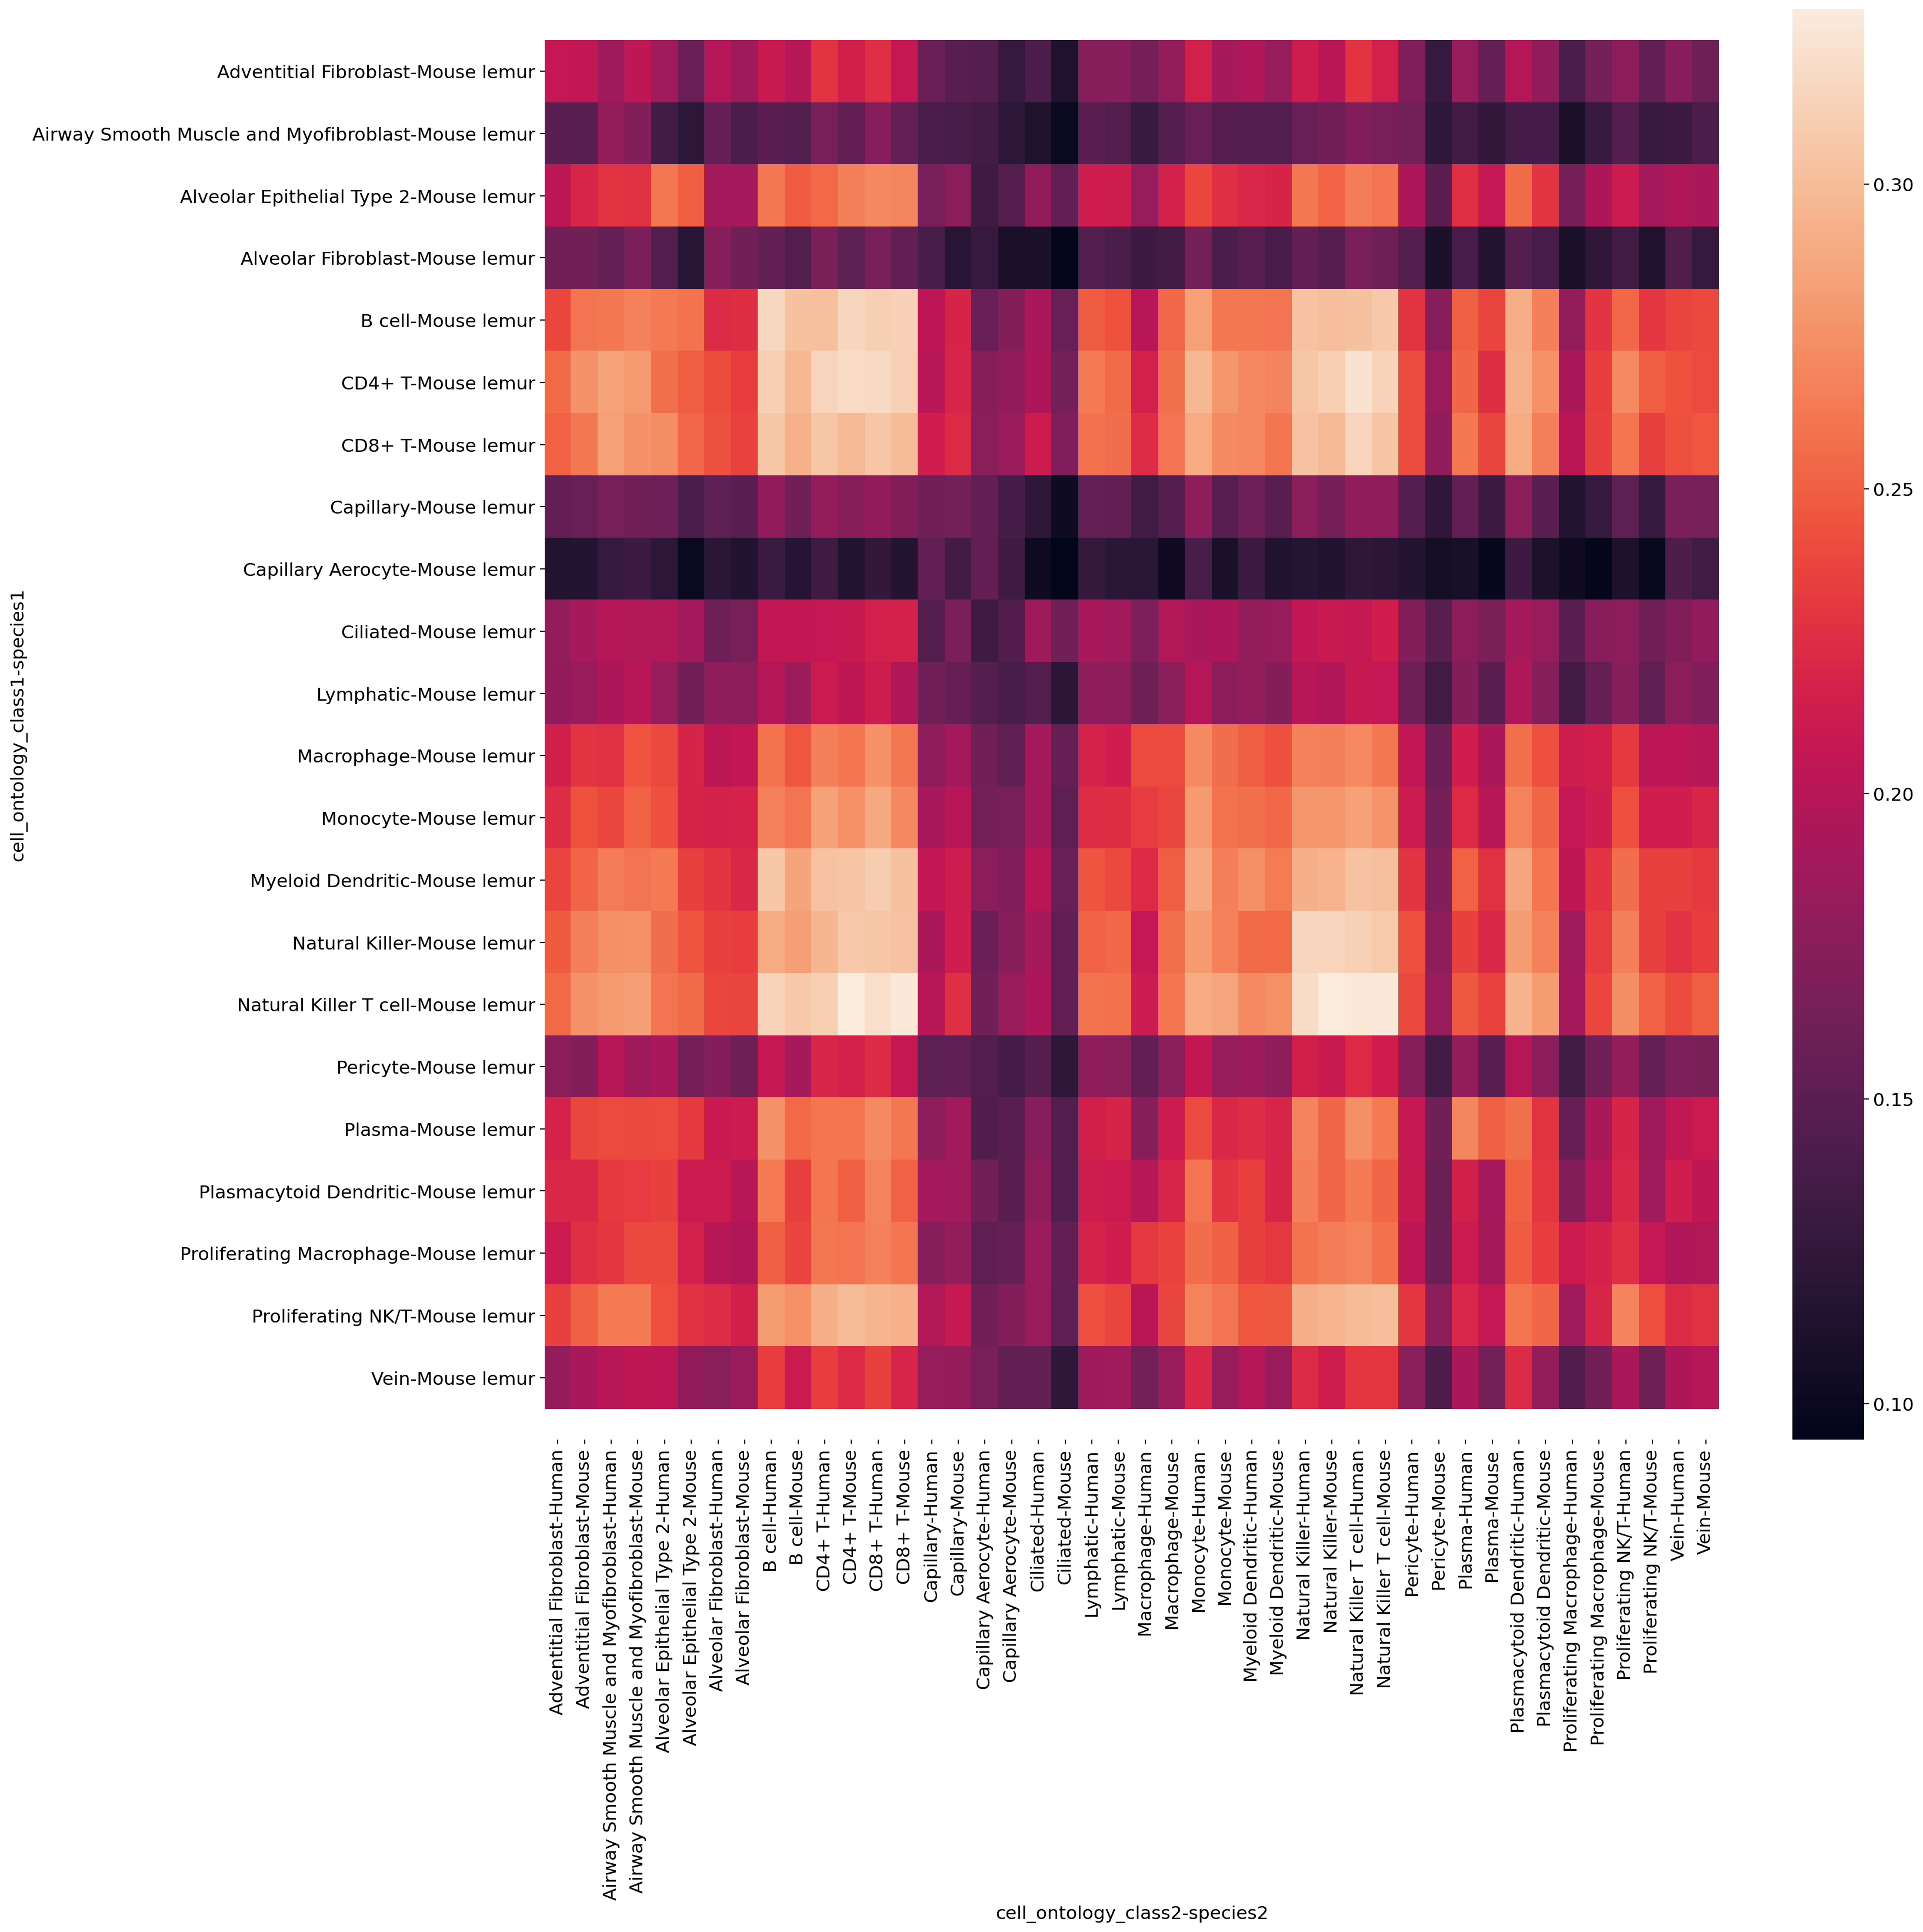

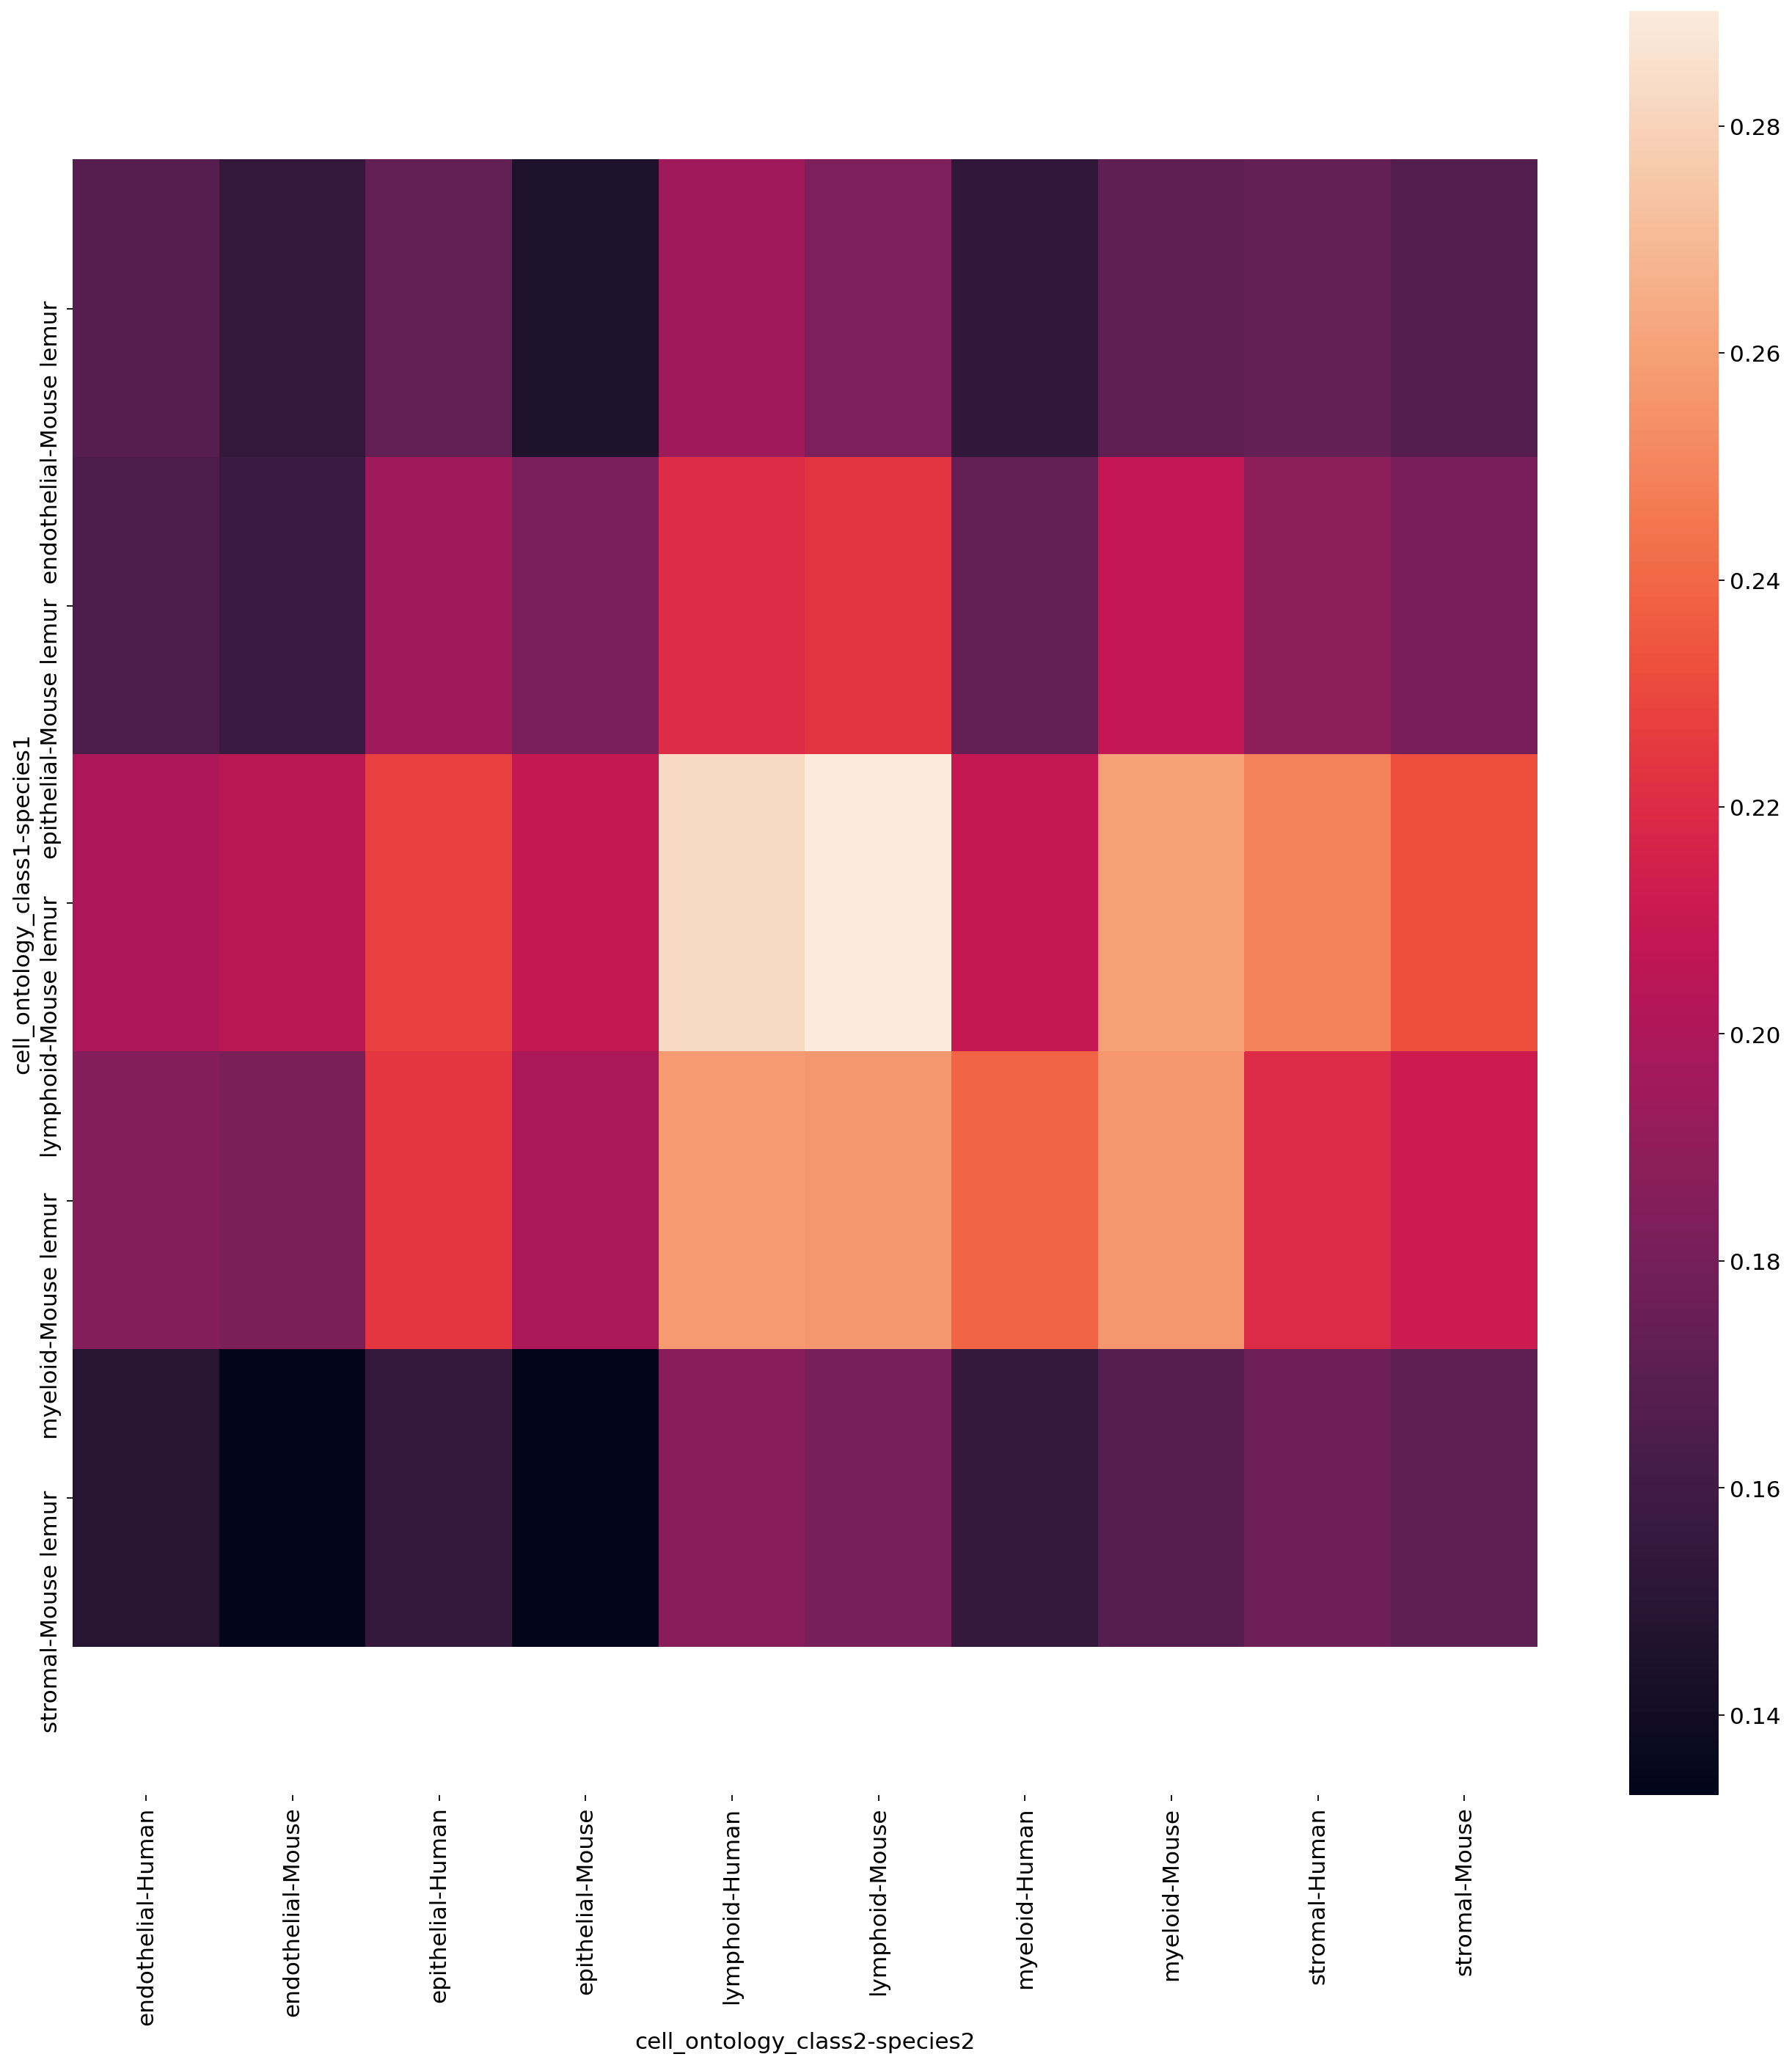

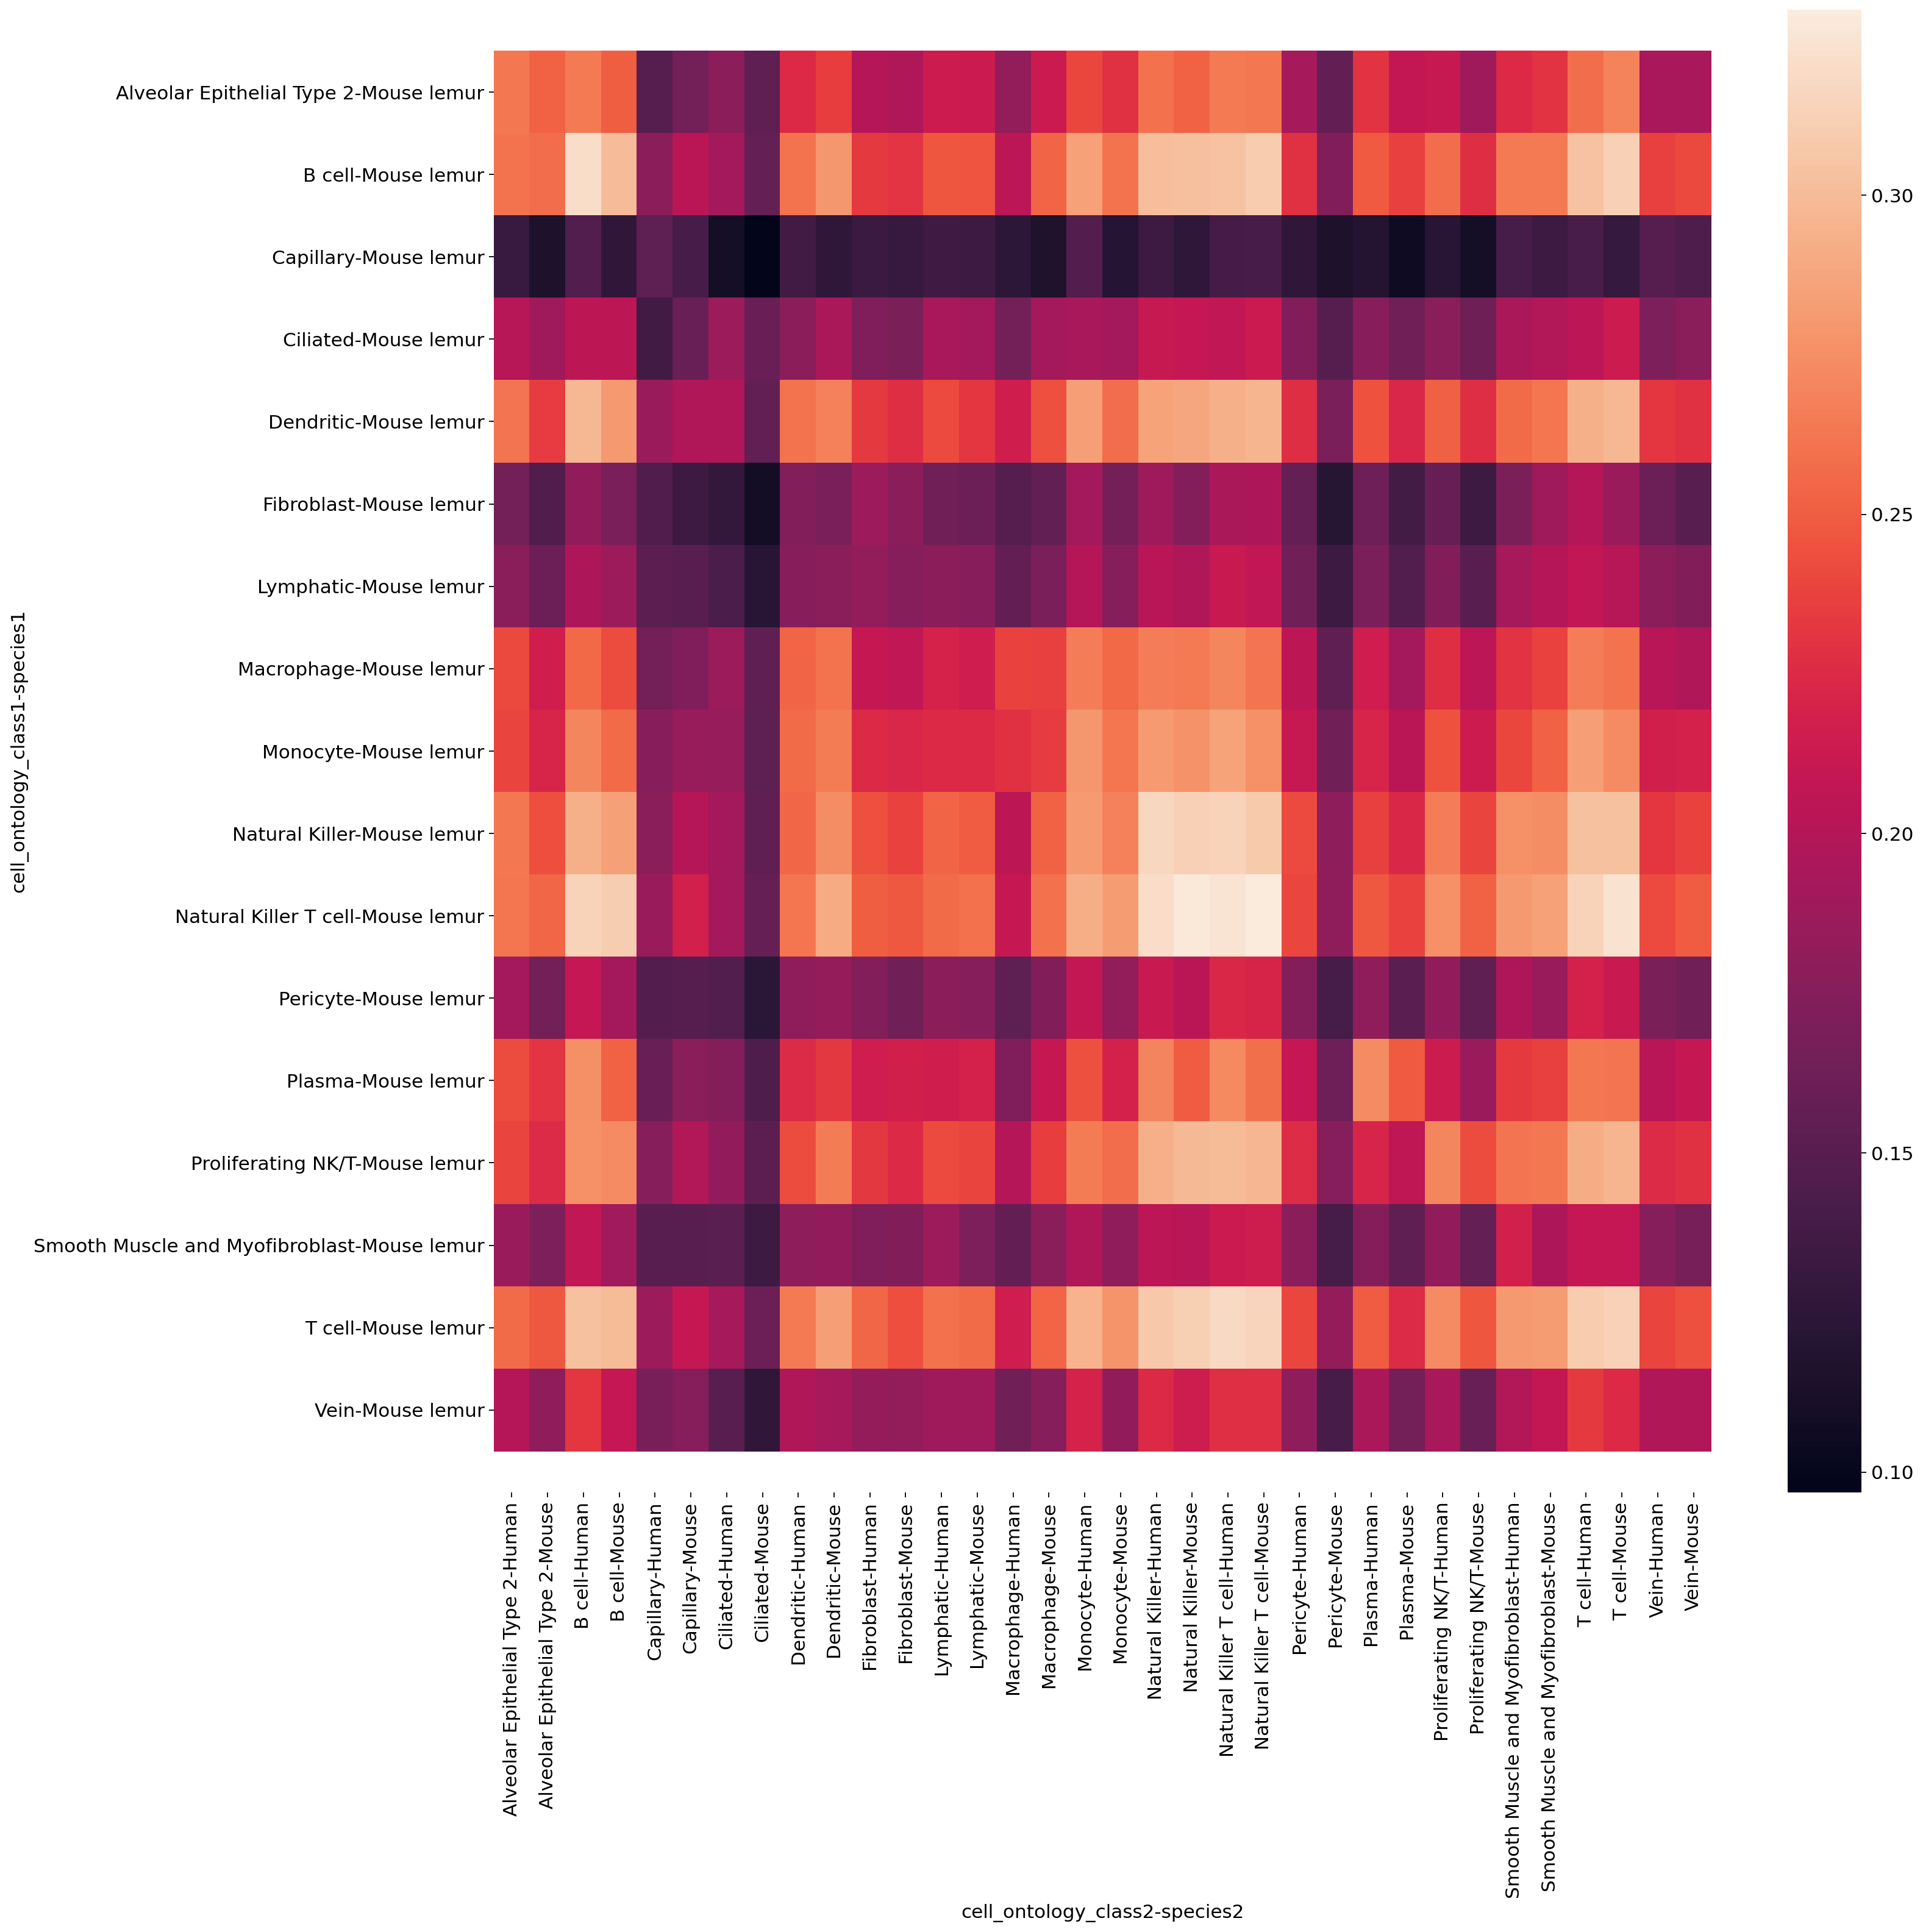

In [37]:
figures_between = {}
for group, dfs in dfs_between.items():
    df = pd.concat(dfs_between[group], ignore_index=True)
    print(len(df))
    figures_between[group] = median_heatmap_between(df)

In [38]:
df = pd.concat(dfs_within["narrow"], ignore_index=True)
print(len(df))

198000


In [ ]:
species_order = ["Human", "Mouse lemur", "Mouse"]
def add_significance_stars(order, pvalues, level3=1e-3, level2=1e-2, level1=1e-1):
    ylabels = []

    for ylabel in order:
        if pvalues[ylabel] < 1e-3:
            ylabel += ' ***'
        elif pvalues[ylabel] < 1e-2:
            ylabel += ' **'
        elif pvalues[ylabel] < 1e-1:
            ylabel += ' *'
        ylabels.append(ylabel)
    return ylabels

def correlation_difference_title(anchor_species):
    other_species = [x for x in species_order if x != anchor_species]
    left = f"{anchor_species}:{other_species[1]}"
    right = f"{anchor_species}:{other_species[0]}"
    title = left + r" $\leftarrow$ $\rightarrow$ " + right
    return title

In [39]:
def corr_diff_within_human_pivoted(df):
    # species1 - Human species2 - anything
    correlation_df_human_vs = df.query('species1 == "Human"')
    # species1 - Human species2 - Human    
    correlation_df_human_vs_human = correlation_df_human_vs.query('species2 == "Human"')
    # species1 - Human species2 - anything but human
    human_vs_lemur_mouse = correlation_df_human_vs.query('species2 != "Human"')
    human_vs_lemur_mouse_pivoted = human_vs_lemur_mouse.pivot_table(index=['species1', 'cell_ontology_class', 'iteration'], columns=['species2'], values='xi')
    corr_difference_dataframe = pd.DataFrame(columns=["celltype1-celltype2", "xi(human, lemur) - xi(human, mouse)", "iteration"])
    diff_list = list(human_vs_lemur_mouse_pivoted['Mouse lemur'].sub(human_vs_lemur_mouse_pivoted['Mouse'], axis = 0).values)
    corr_difference_dataframe["xi(human, lemur) - xi(human, mouse)"] = diff_list
    # comparison between human and other species as violin plot
    mi = human_vs_lemur_mouse_pivoted.index
    iteration = mi.get_level_values(2)
    iteration_list = list(iteration.values)
    cell_types = mi.get_level_values(1)
    cell_types_list = list(cell_types.values)
    cell_type_modified_list = []
    for index, cell_type in enumerate(cell_types_list):
        for compartment_group, narrow_group in SUBGROUPS.items():
            if cell_type in narrow_group:
                compartment = compartment_group
                break
        cell_type_modified_list.append(compartment + " - " + cell_type)

    corr_difference_dataframe = pd.DataFrame(columns=["compartment_narrow", "xi(human, lemur) - xi(human, mouse)", "iteration"])
    diff = human_vs_lemur_mouse_pivoted['Mouse lemur'].sub(human_vs_lemur_mouse_pivoted['Mouse'], axis = 0)
    diff_list = list(diff.values)
    corr_difference_dataframe["xi(human, lemur) - xi(human, mouse)"] = diff_list
    corr_difference_dataframe["iteration"] = iteration_list
    corr_difference_dataframe["compartment_narrow"] = cell_type_modified_list
    corr_difference_dataframe = corr_difference_dataframe.reset_index()

    assert len(diff_list) == len(iteration_list) == len(cell_type_modified_list)
    x = "xi(human, lemur) - xi(human, mouse)"
    means = corr_difference_dataframe.groupby("compartment_narrow")[x].mean().sort_values(ascending=False)

    # apply ttest on cell_ontology_class for species1 - Human species2 - anything dataframe
    correlation_ttests = corr_difference_dataframe.groupby('compartment_narrow').apply(compute_ttest_1samp, "xi(human, lemur) - xi(human, mouse)")
    correlation_ttests['p_value_bonferonni'] = correlation_ttests.p_value * len(correlation_ttests.index)
    ylabels = add_significance_stars(means.index, correlation_ttests['p_value_bonferonni'])
    title = correlation_difference_title("Human")

    # comparison between human and other species as violin plot
    fig, ax = plt.subplots(figsize=(4, 6))
    colors = {x: compartment_to_color[x.split(' - ')[0].lower()] for x in corr_difference_dataframe.compartment_narrow.unique()}
    y = 'compartment_narrow'
    x = "xi(human, lemur) - xi(human, mouse)"

    g = sns.FacetGrid(data=corr_difference_dataframe, aspect=2)
    g.map(sns.barplot, x, y, order=means.index, palette=colors)
    g.map(plt.axvline, x=0, color="black")
    g.set(xlabel='$\Delta$ xi correlation', title=title, yticklabels=ylabels)


In [40]:
def corr_diff_within_lemur_pivoted(df):
    # species1 - Lemur species2 - anything
    correlation_df_lemur_vs = df.query('species1 == "Mouse lemur"')
    # species1 - lemur species2 - lemur    
    correlation_df_lemur_vs_lemur = correlation_df_lemur_vs.query('species2 == "Mouse lemur"')
    # species1 - lemur species2 - anything but lemur
    lemur_vs_human_mouse = correlation_df_lemur_vs.query('species2 != "Mouse lemur"')
    lemur_vs_human_mouse_pivoted = lemur_vs_human_mouse.pivot_table(index=['species1', 'cell_ontology_class', 'iteration'], columns=['species2'], values='xi')
    mi = lemur_vs_human_mouse_pivoted.index
    diff = lemur_vs_human_mouse_pivoted["Human"] - lemur_vs_human_mouse_pivoted["Mouse"]
    iteration = mi.get_level_values(2)
    iteration_list = list(iteration.values)
    cell_types = mi.get_level_values(1)
    cell_types_list = list(cell_types.values)
    cell_type_modified_list = []
    for index, cell_type in enumerate(cell_types_list):
        for compartment_group, narrow_group in SUBGROUPS.items():
            if cell_type in narrow_group:
                compartment = compartment_group
                break
        cell_type_modified_list.append(compartment + " - " + cell_type)

    corr_difference_dataframe = pd.DataFrame(columns=["compartment_narrow", "xi(lemur, human) - xi(lemur, mouse)", "iteration"])
    diff = lemur_vs_human_mouse_pivoted['Human'].sub(lemur_vs_human_mouse_pivoted['Mouse'], axis = 0)
    diff_list = list(diff.values)
    corr_difference_dataframe["xi(lemur, human) - xi(lemur, mouse)"] = diff_list
    corr_difference_dataframe["iteration"] = iteration_list
    corr_difference_dataframe["compartment_narrow"] = cell_type_modified_list
    corr_difference_dataframe = corr_difference_dataframe.reset_index()

    assert len(diff_list) == len(iteration_list) == len(cell_type_modified_list)
    x = "xi(lemur, human) - xi(lemur, mouse)"
    means = corr_difference_dataframe.groupby("compartment_narrow")[x].mean().sort_values(ascending=False)

    # apply ttest on cell_ontology_class for species1 - Human species2 - anything dataframe
    correlation_ttests = corr_difference_dataframe.groupby('compartment_narrow').apply(compute_ttest_1samp, "xi(lemur, human) - xi(lemur, mouse)")
    correlation_ttests['p_value_bonferonni'] = correlation_ttests.p_value * len(correlation_ttests.index)

    ylabels = add_significance_stars(means.index, correlation_ttests['p_value_bonferonni'])
    title = correlation_difference_title("Human")

    # comparison between human and other species as violin plot
    fig, ax = plt.subplots(figsize=(4, 6))
    colors = {x: compartment_to_color[x.split(' - ')[0].lower()] for x in corr_difference_dataframe.compartment_narrow.unique()}
    y = 'compartment_narrow'
    x = "xi(human, lemur) - xi(human, mouse)"

    g = sns.FacetGrid(data=corr_difference_dataframe, aspect=2)
    g.map(sns.barplot, x, y, order=means.index, palette=colors)
    g.map(plt.axvline, x=0, color="black")
    g.set(xlabel='$\Delta$ xi correlation', title=title, yticklabels=ylabels)


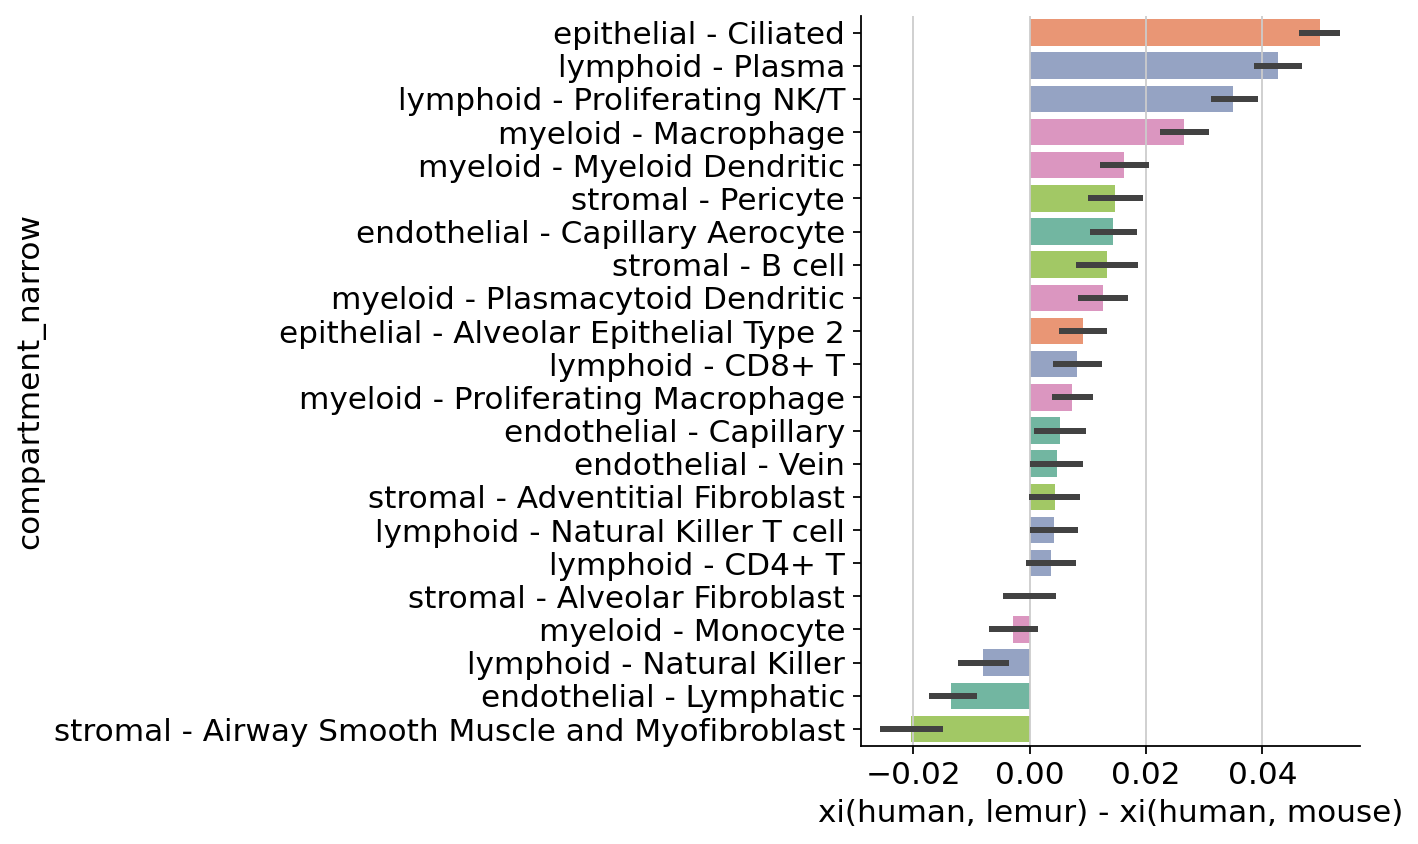

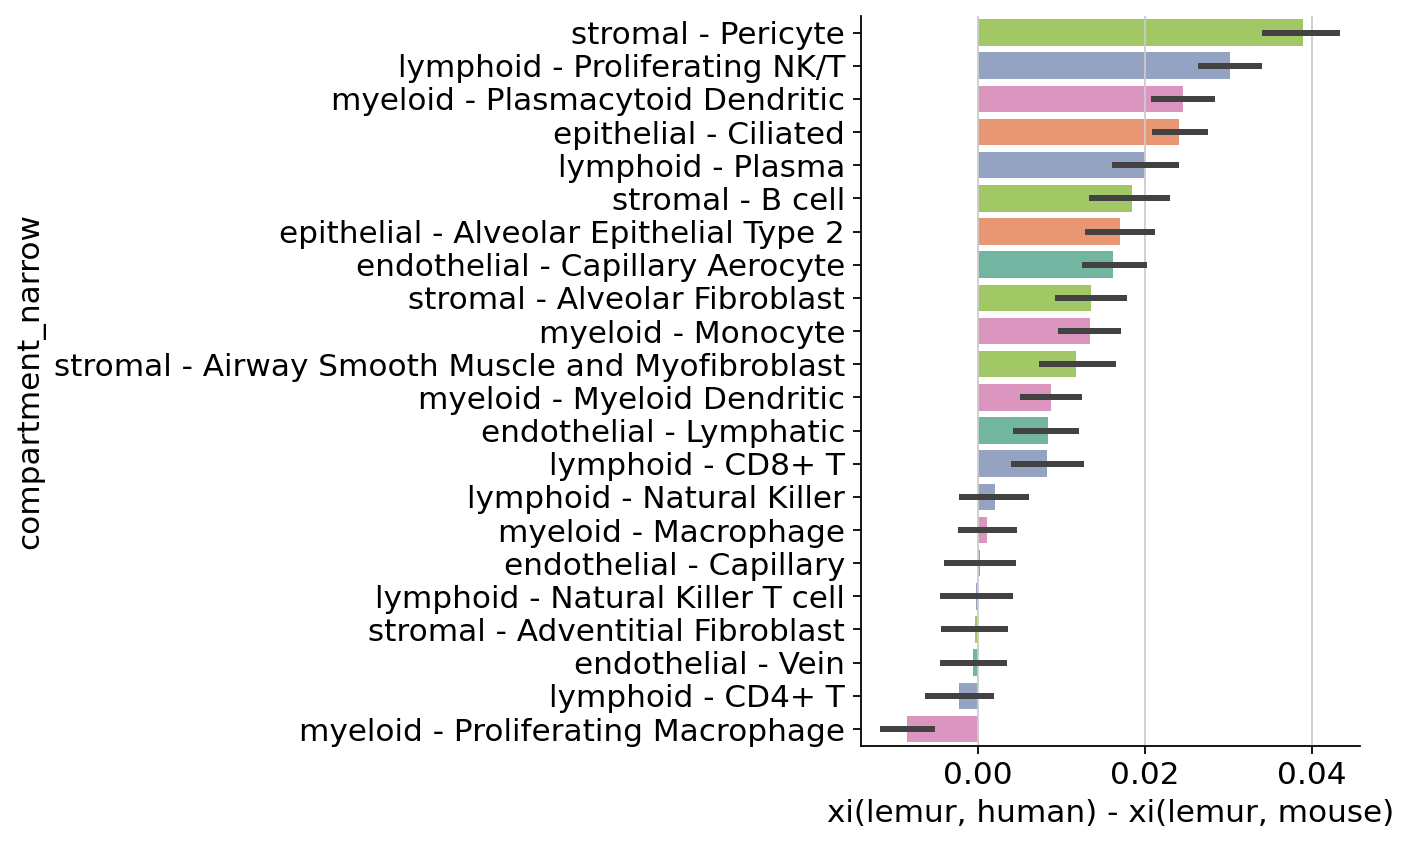

In [41]:
corr_diff_within_human_pivoted(df)
corr_diff_within_lemur_pivoted(df)

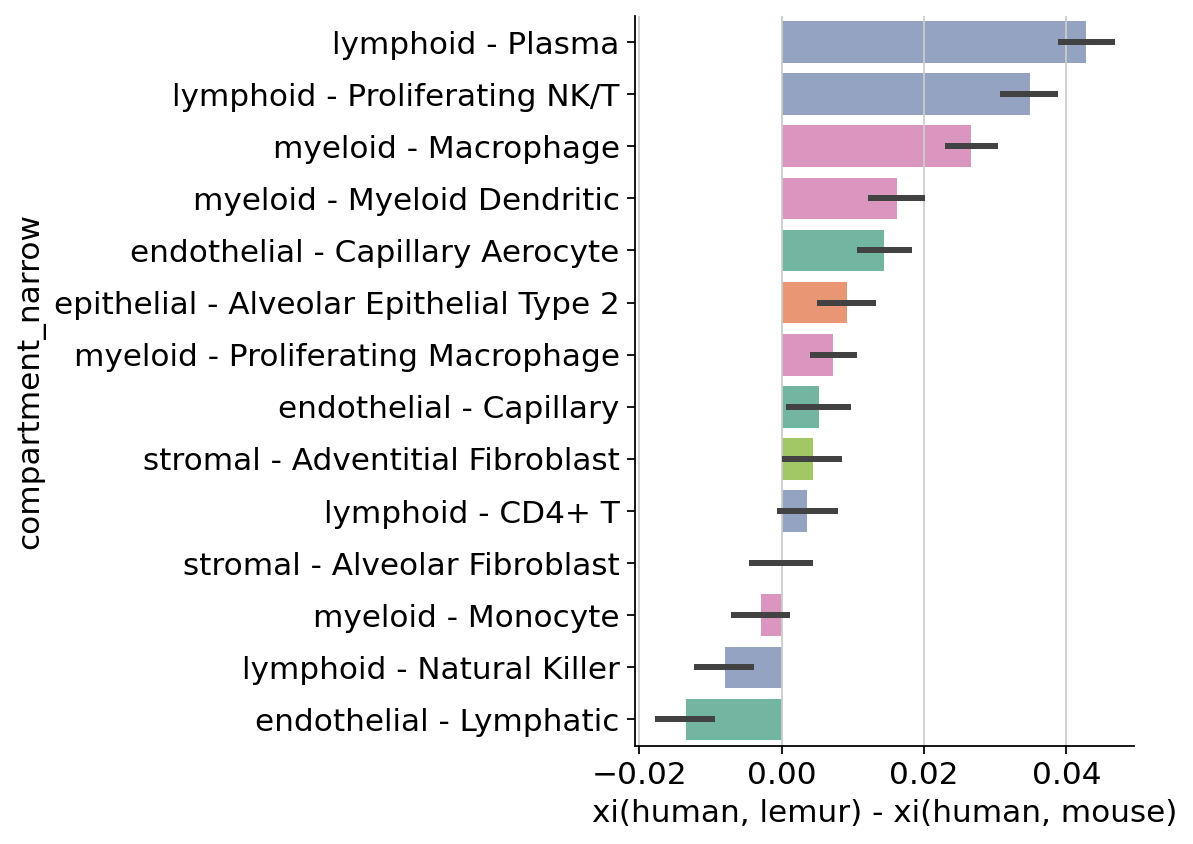

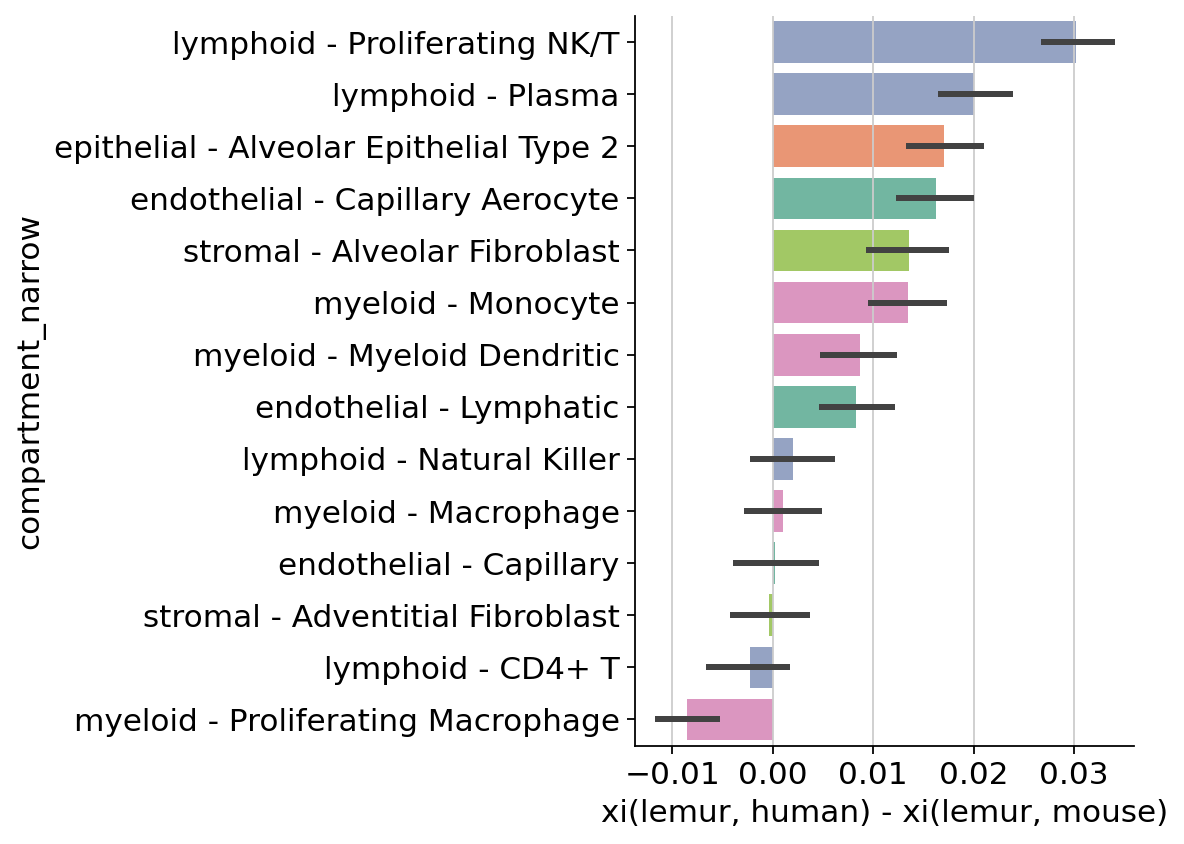

In [42]:
filtered_df = df[df['cell_ontology_class'].isin(NARROW_CELL_TYPES_SIGNIFICANT)]
corr_diff_within_human_pivoted(filtered_df)
corr_diff_within_lemur_pivoted(filtered_df)

In [43]:
def corr_diff(df):
    # species1 - Human species2 - anything
    correlation_df_human_vs = df.query('species1 == "Human"')
    # species1 - Human species2 - Human    
    correlation_df_human_vs_human = correlation_df_human_vs.query('species2 == "Human"')
    # species1 - Human species2 - anything but human
    human_vs_lemur_mouse = correlation_df_human_vs.query('species2 != "Human"')
    human_vs_lemur_mouse_pivoted = human_vs_lemur_mouse.pivot_table(index=['species1', 'cell_ontology_class1', 'cell_ontology_class2', 'iteration'], columns=['species2'], values='xi')
    print(human_vs_lemur_mouse_pivoted.head())
    corr_difference_dataframe = pd.DataFrame(columns=["celltype1-celltype2", "xi(human, lemur) - xi(human, mouse)", "iteration"])
    for index, row in human_vs_lemur_mouse_pivoted.iterrows():
        celltype1_celltype2 = row.name[1] + "_" + row.name[2]
        corr_difference_dataframe = corr_difference_dataframe.append(
            {"celltype1-celltype2": celltype1_celltype2,
             "xi(human, lemur) - xi(human, mouse)": row["Mouse lemur"] - row["Mouse"],
             "iteration": row.name[3]}, ignore_index=True)
    # comparison between human and other species as bar plot
    g = sns.catplot(
        y="celltype1-celltype2", x="xi(human, lemur) - xi(human, mouse)", 
        data=corr_difference_dataframe, kind='box', aspect=0.5, height=6)
    g.fig.set_figheight(12)
    g.fig.set_figwidth(12)
    plt.tight_layout()

153000
species2                                                                     Mouse  \
species1 cell_ontology_class1       cell_ontology_class2       iteration             
Human    Alveolar Epithelial Type 2 Alveolar Epithelial Type 2 0          0.216292   
                                                               1          0.207826   
                                                               2          0.195267   
                                                               3          0.325651   
                                                               4          0.281711   

species2                                                                  Mouse lemur  
species1 cell_ontology_class1       cell_ontology_class2       iteration               
Human    Alveolar Epithelial Type 2 Alveolar Epithelial Type 2 0             0.259736  
                                                               1             0.226149  
                                      

/home/pranathi/miniconda3/lib/python3.7/site-packages/seaborn-0.10.0-py3.7.egg/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


198000
species2                                                             Mouse  \
species1 cell_ontology_class1   cell_ontology_class2   iteration             
Human    Adventitial Fibroblast Adventitial Fibroblast 0          0.196041   
                                                       1          0.193254   
                                                       2          0.270543   
                                                       3          0.338171   
                                                       4          0.257156   

species2                                                          Mouse lemur  
species1 cell_ontology_class1   cell_ontology_class2   iteration               
Human    Adventitial Fibroblast Adventitial Fibroblast 0             0.307668  
                                                       1             0.231681  
                                                       2             0.226641  
                                              

/home/pranathi/miniconda3/lib/python3.7/site-packages/seaborn-0.10.0-py3.7.egg/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


45000
species2                                                         Mouse  \
species1 cell_ontology_class1 cell_ontology_class2 iteration             
Human    endothelial          endothelial          0          0.173444   
                                                   1          0.203478   
                                                   2          0.051222   
                                                   3          0.197776   
                                                   4          0.308409   

species2                                                      Mouse lemur  
species1 cell_ontology_class1 cell_ontology_class2 iteration               
Human    endothelial          endothelial          0             0.212859  
                                                   1             0.195056  
                                                   2             0.209258  
                                                   3             0.179389  
                   

/home/pranathi/miniconda3/lib/python3.7/site-packages/seaborn-0.10.0-py3.7.egg/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


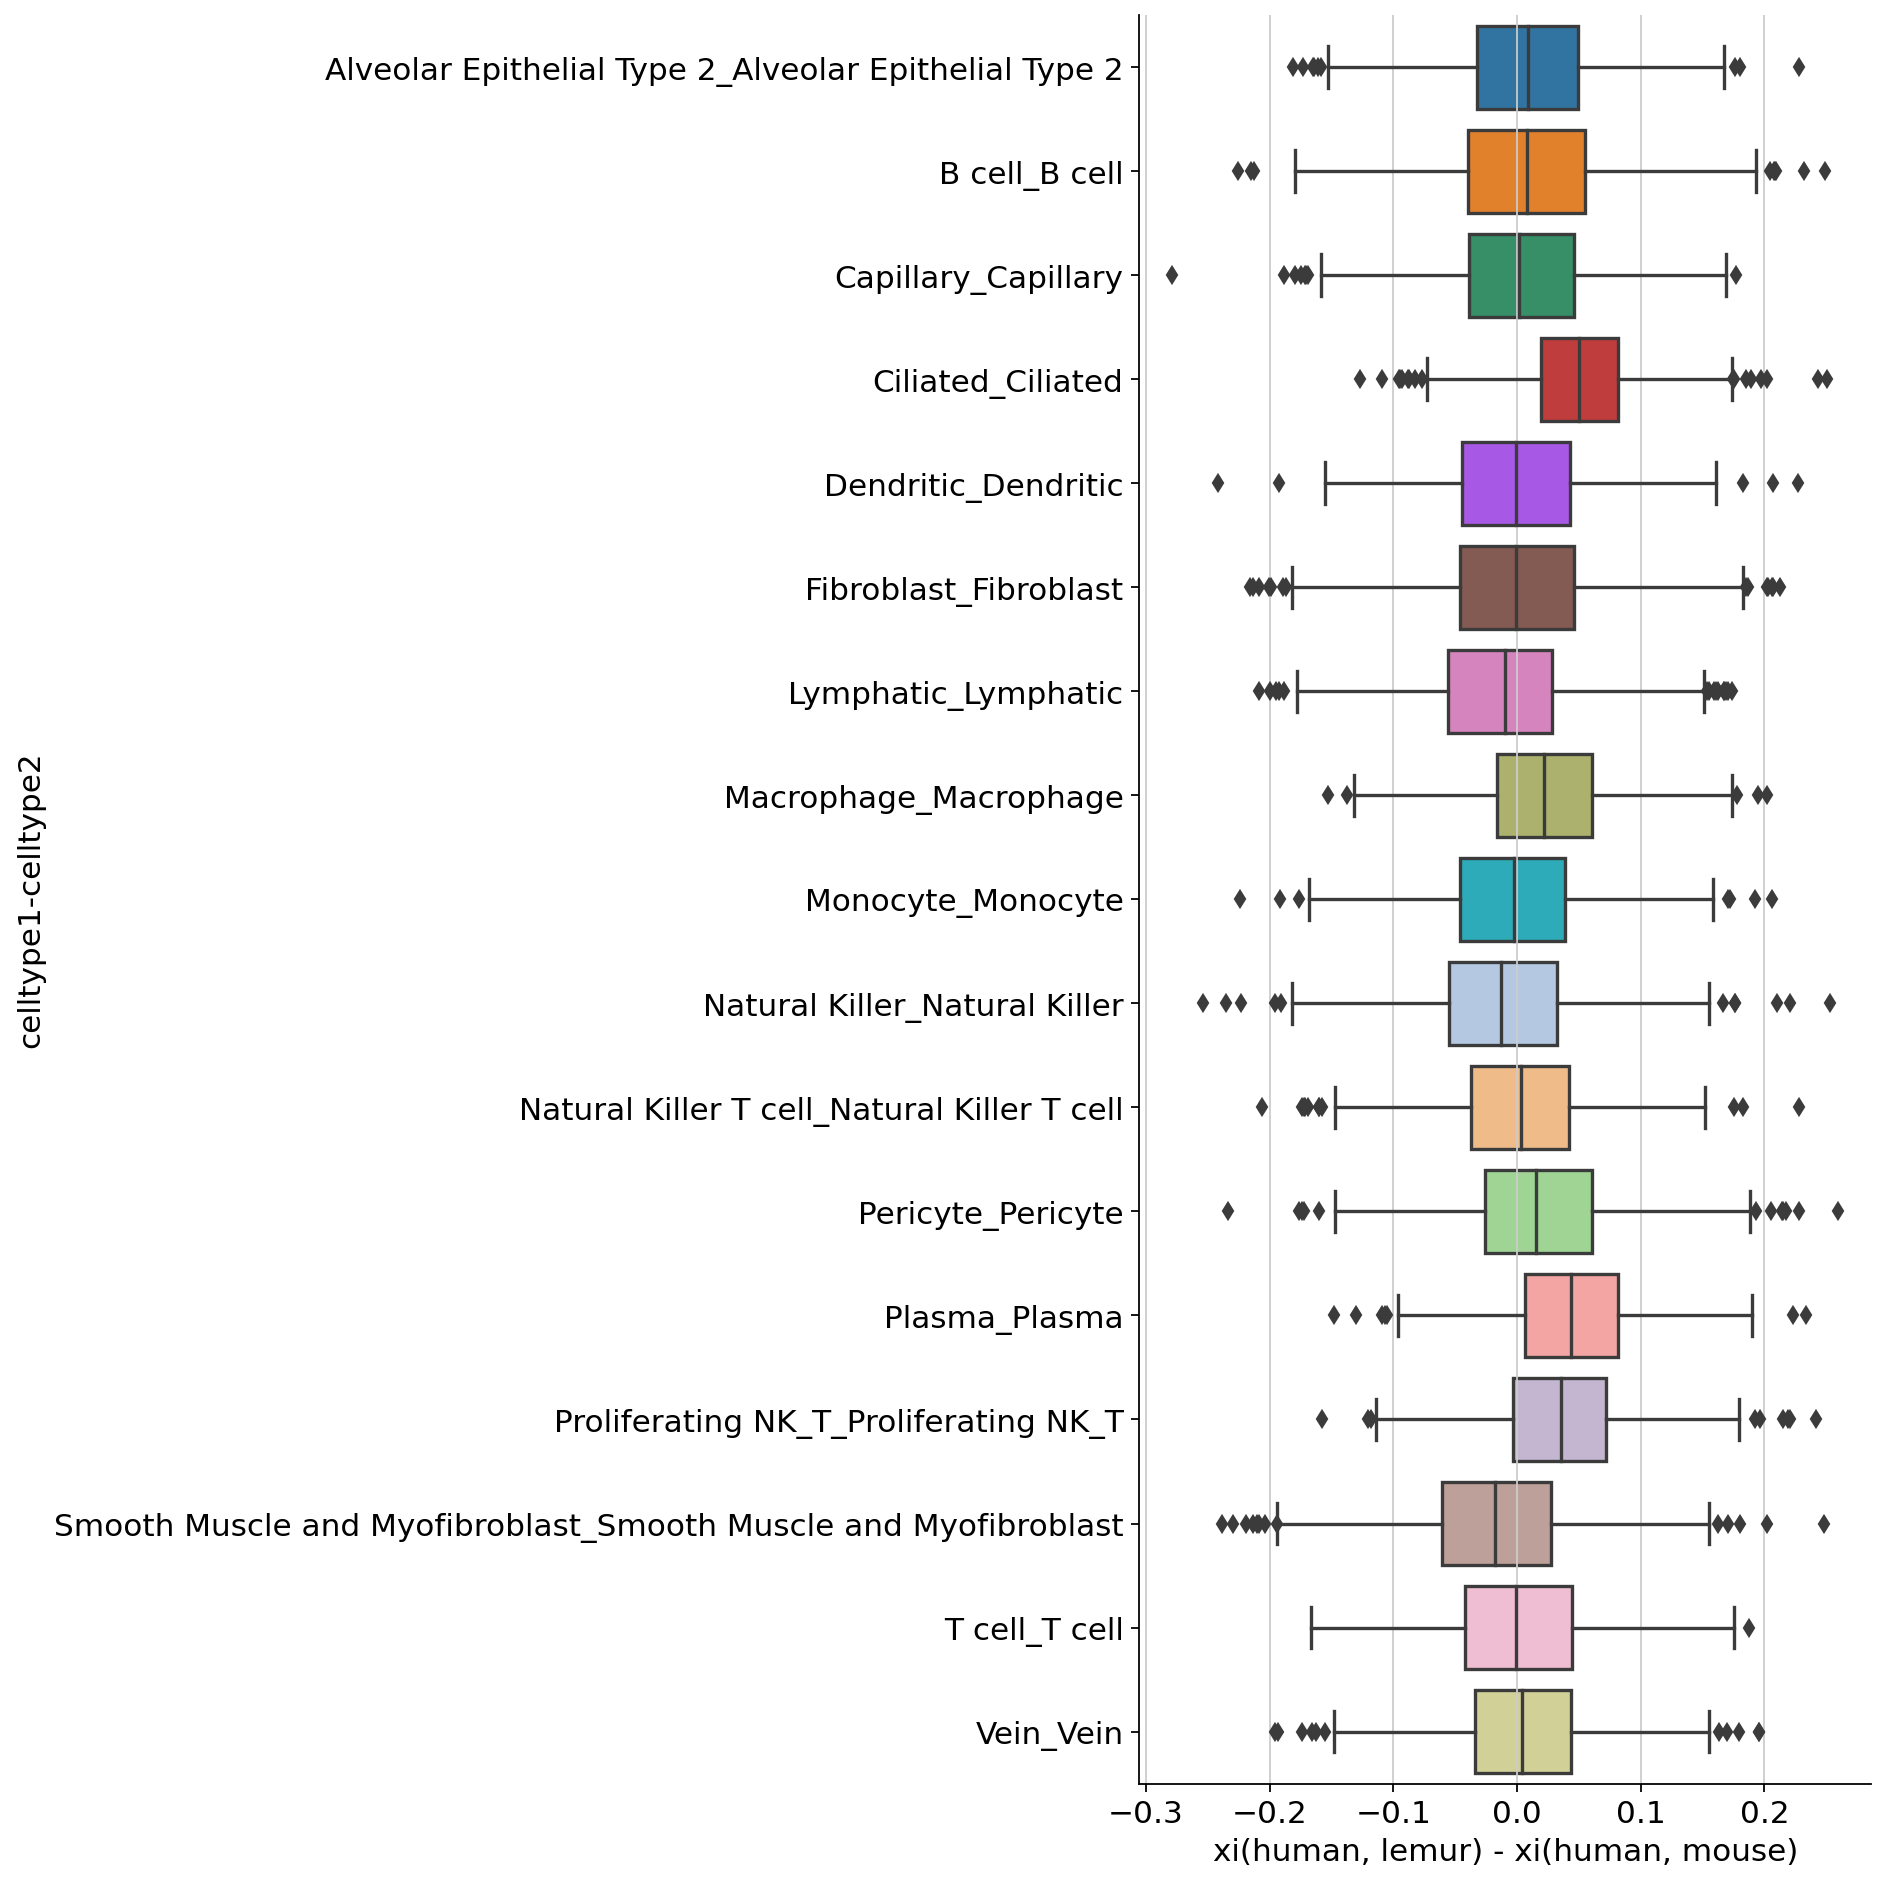

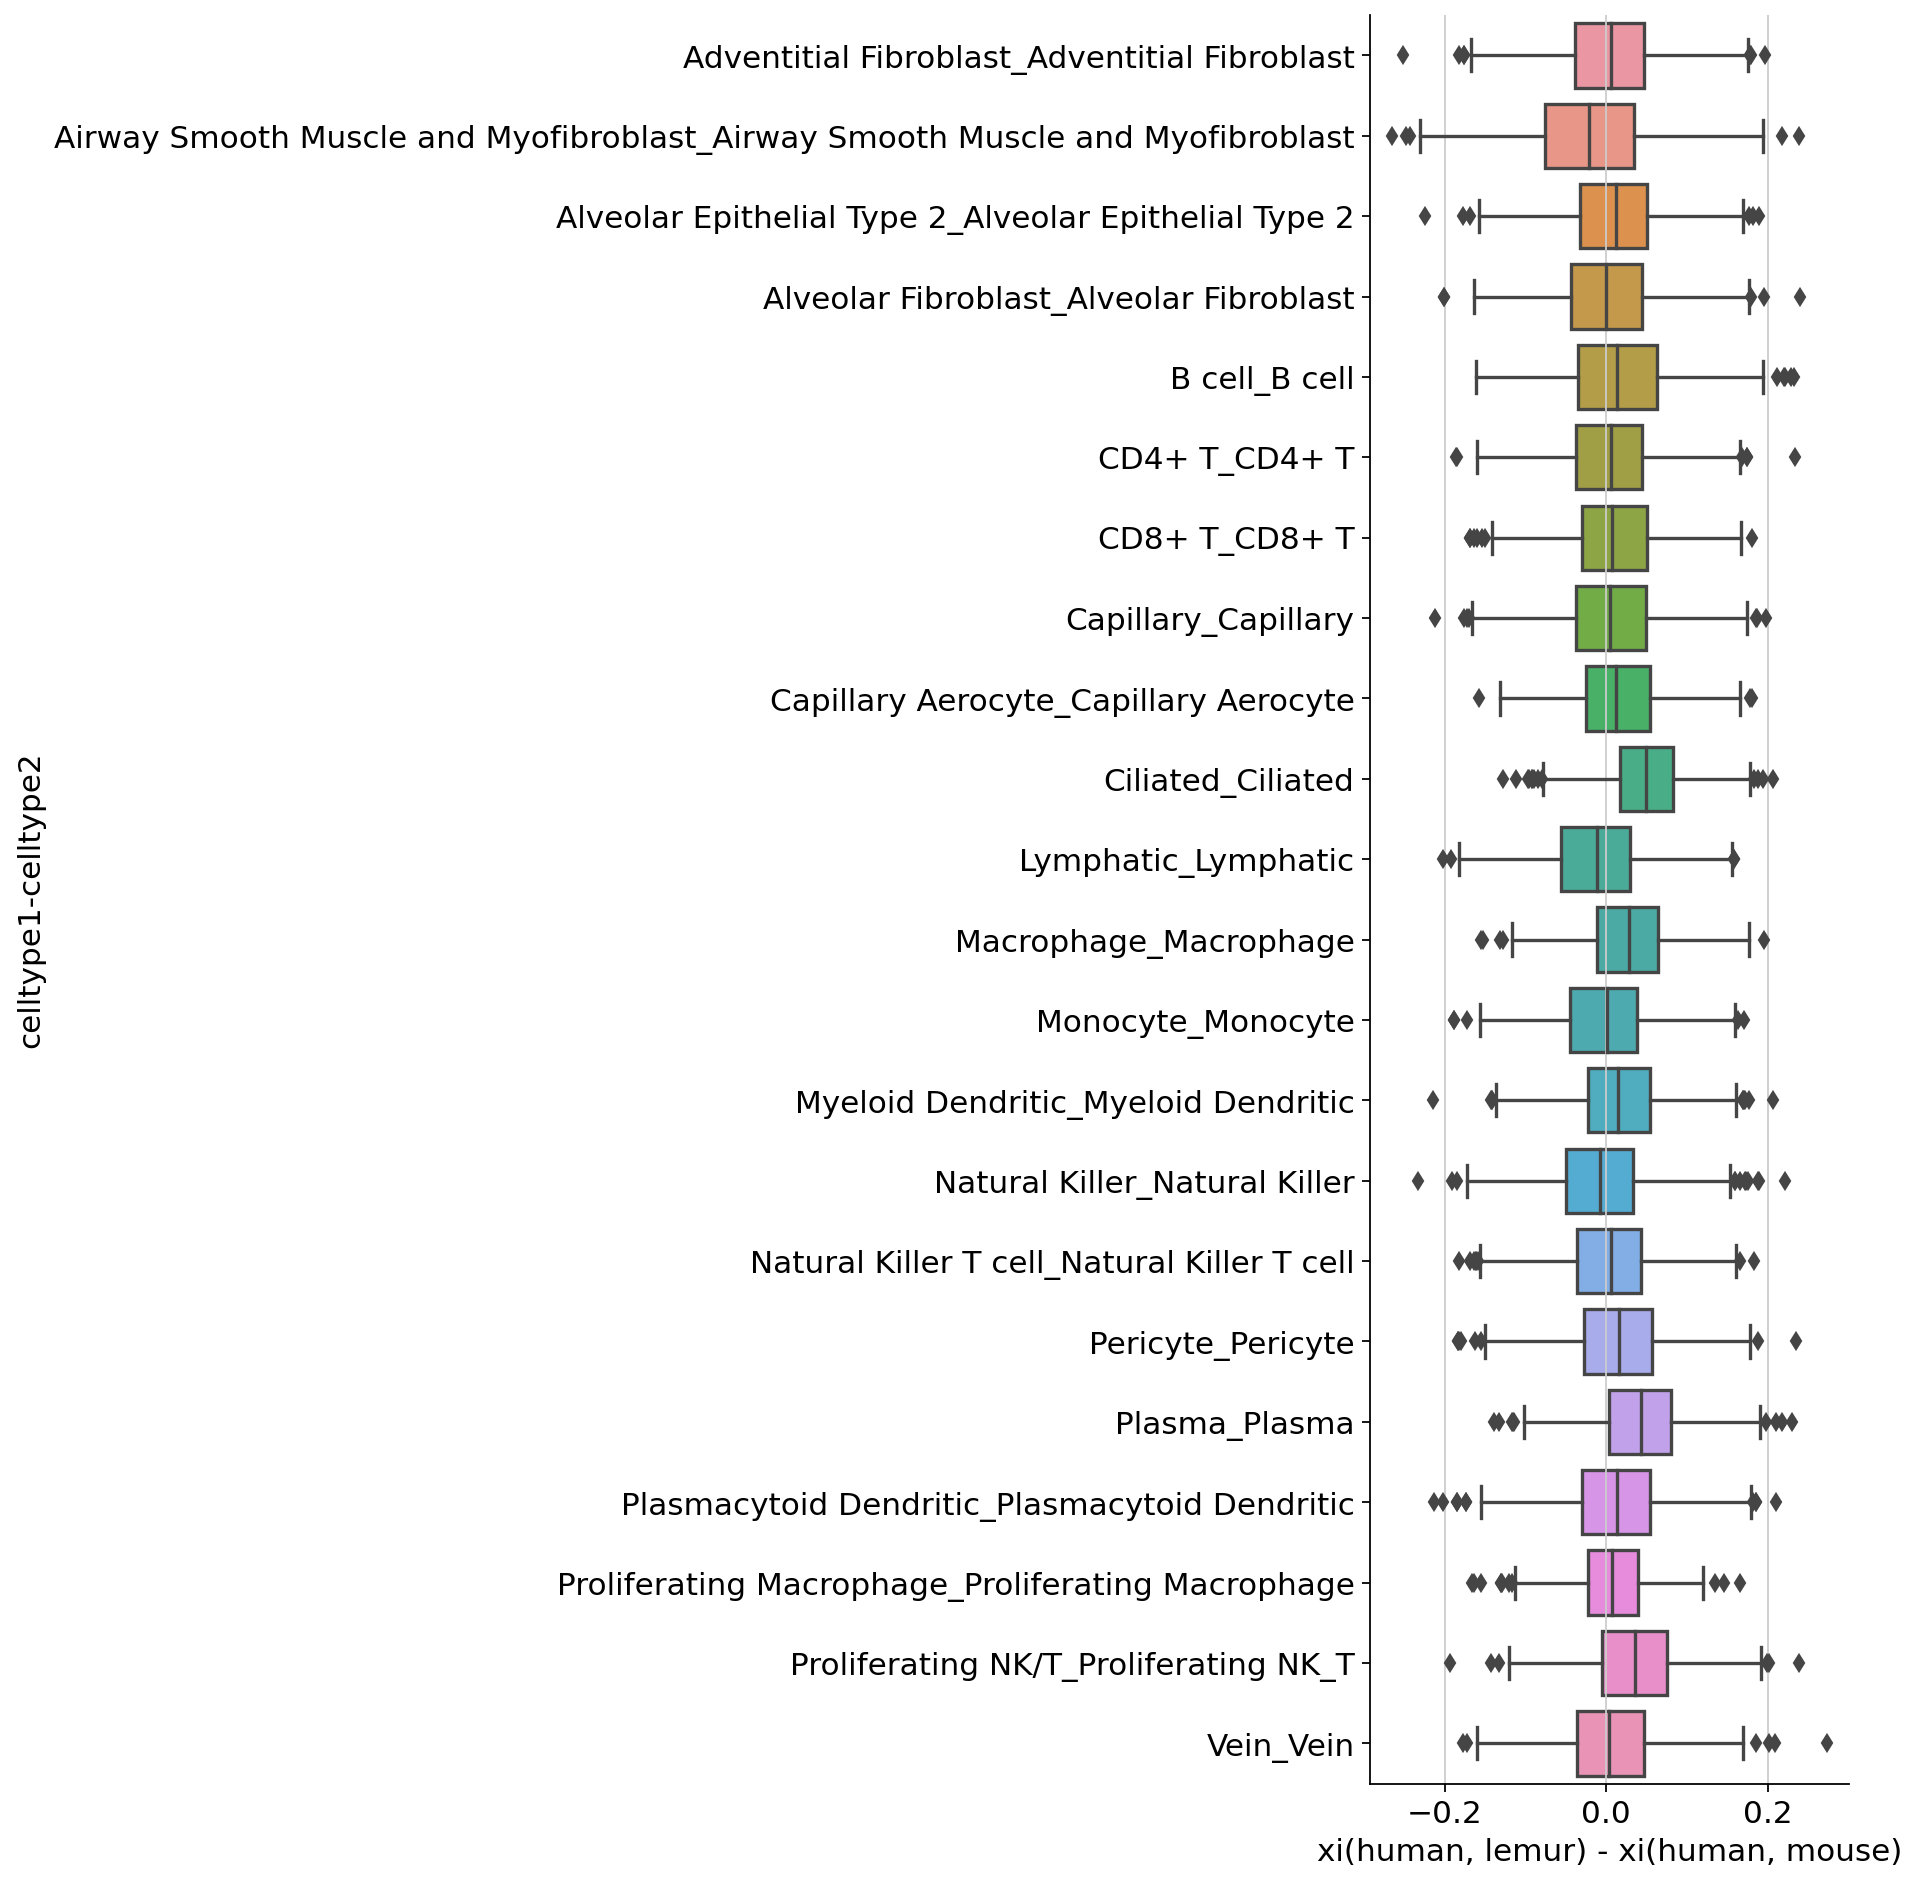

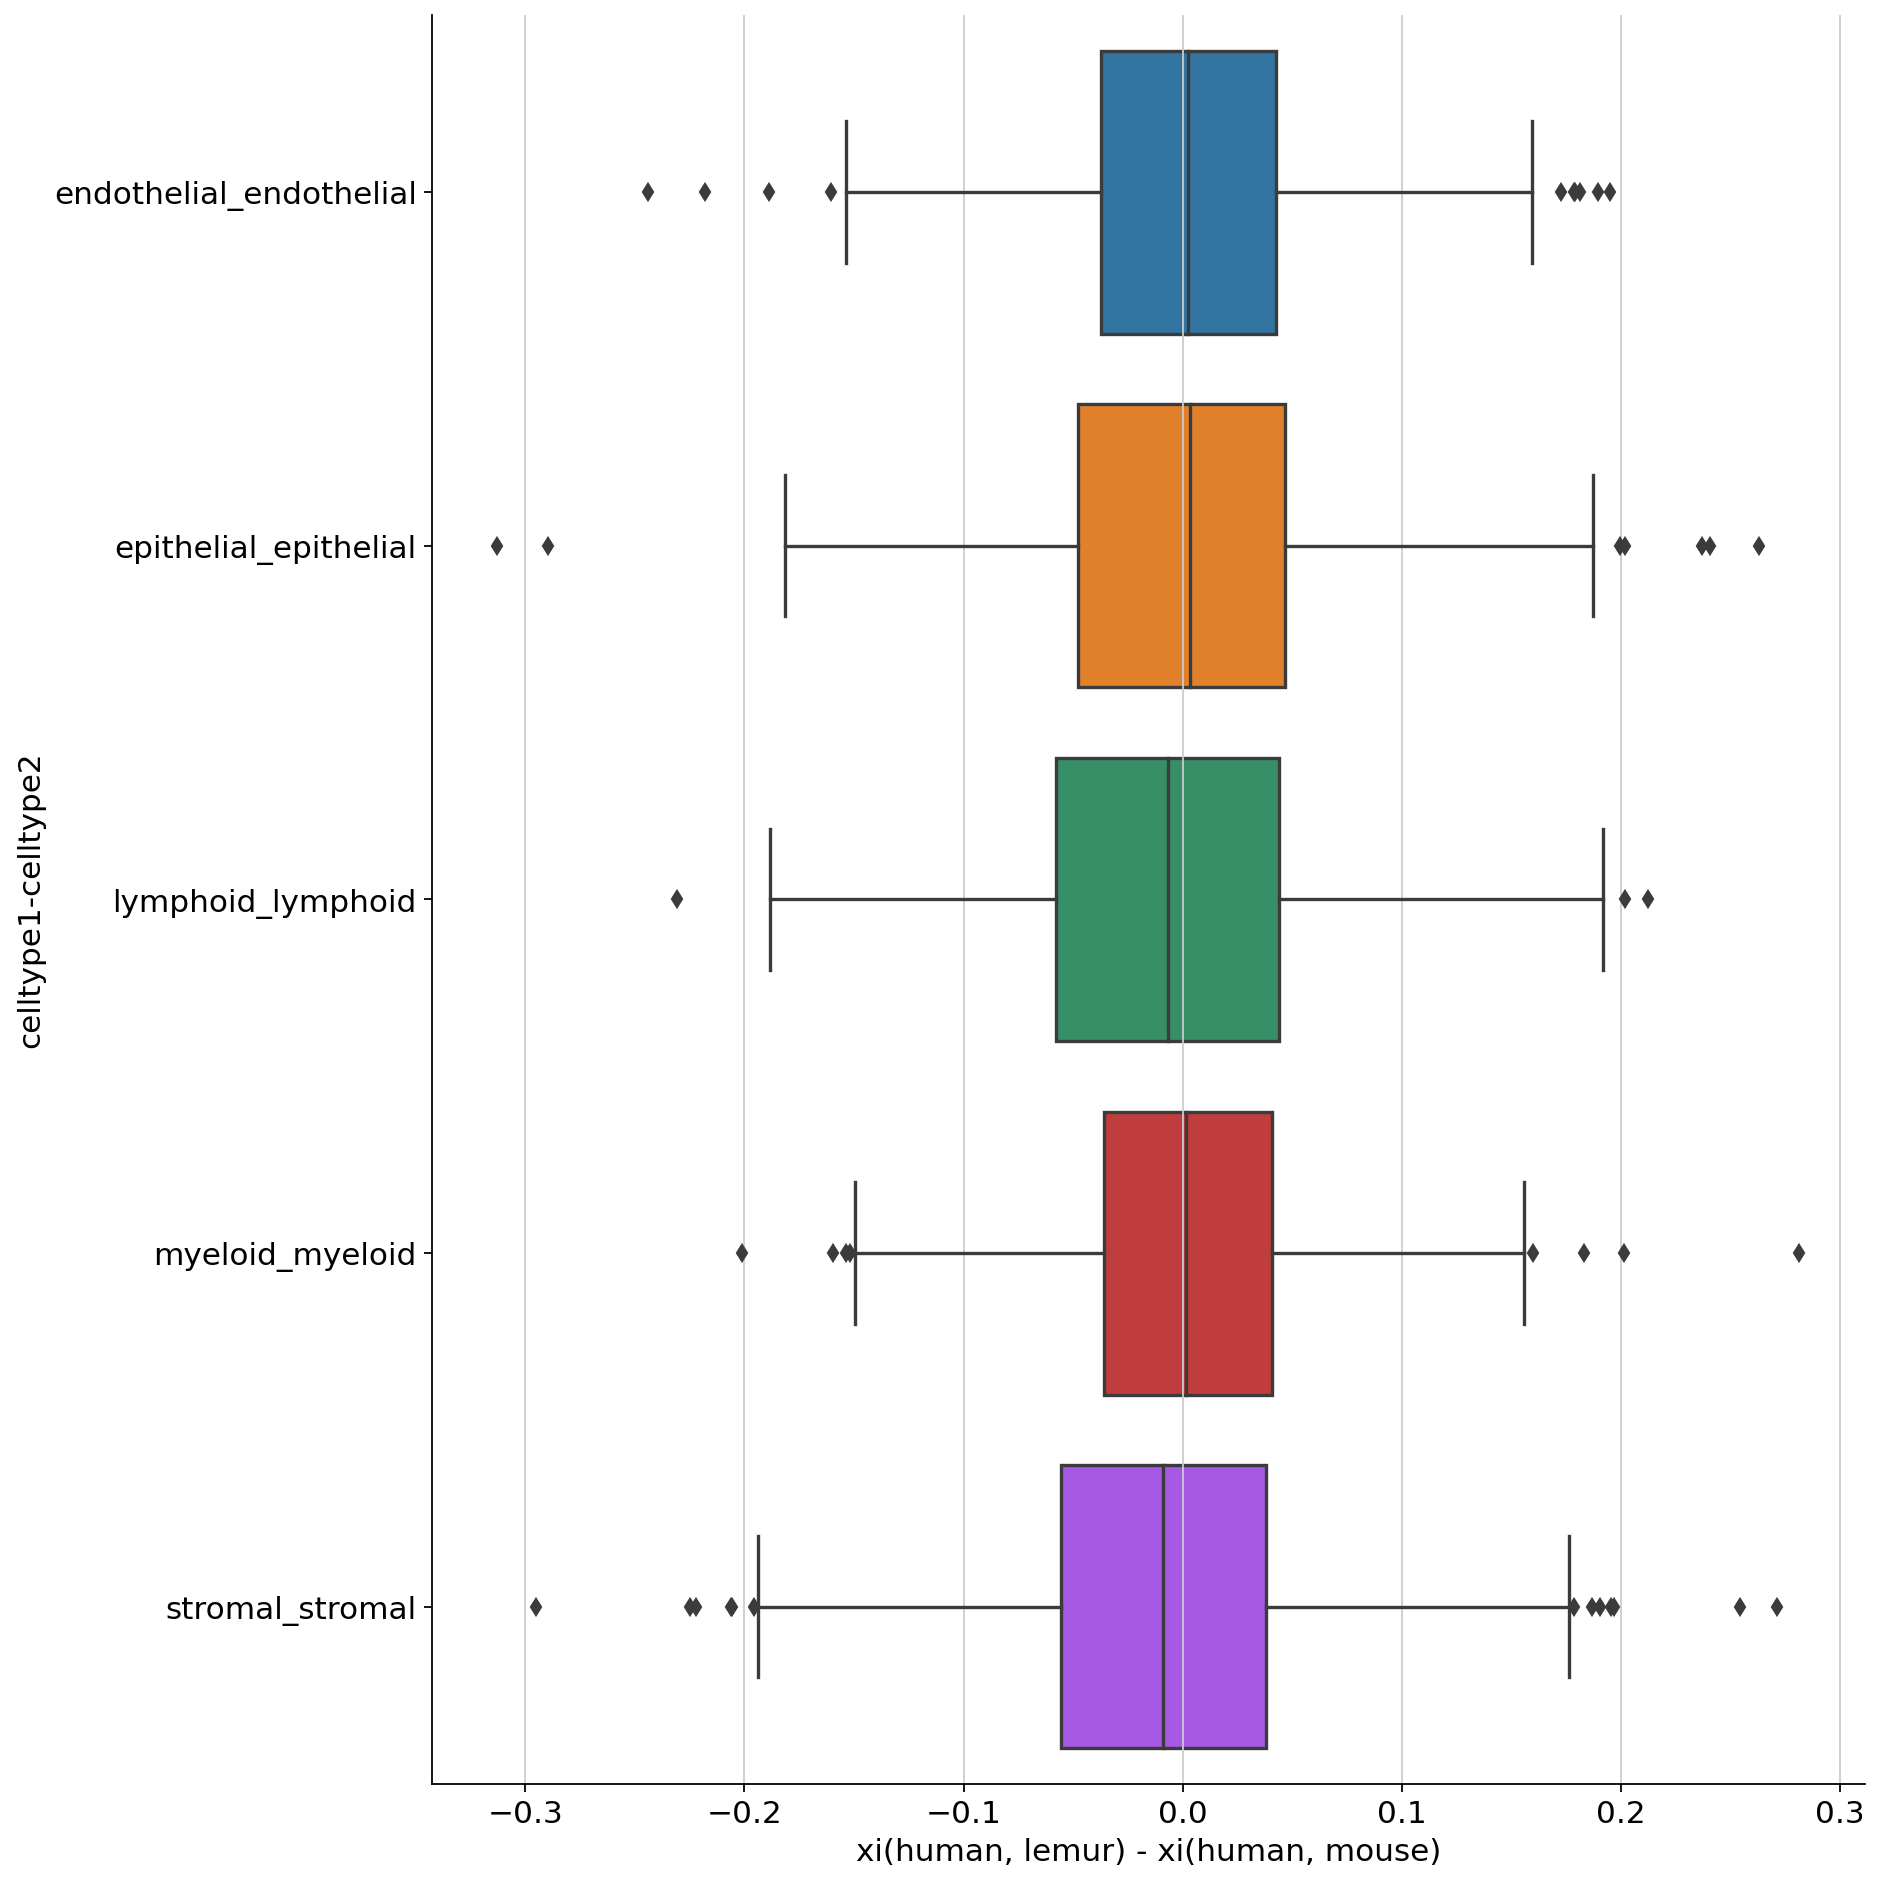

In [44]:
dfs_within = defaultdict(list)
for file in within_celltypes:
    for group in GROUPS:
        if group in file:
            df = pd.read_parquet(file)
            df = df.rename(columns={group + "_group": "cell_ontology_class1"})
            df['cell_ontology_class2'] = [file.partition("_zero_")[-1].replace(".parquet", "")] * len(df)
            dfs_within[group].append(df)

figures_within_corr_diff = {}
for group, dfs in dfs_within.items():
    df = pd.concat(dfs, ignore_index=True)
    print(len(df))
    figures_within_corr_diff[group] = corr_diff(df)